# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Variable Renewable Energy (VRE) assessment and forecast

### Project objectives
<div class="alert alert-block alert-info">

- Assess the onshore wind or solar photovoltaic hourly production over in metropolitan France regions using climate data and capacity factor observations.
- Predict the VRE power ahead of time.
</div>

### Dataset

- Observed monthly VRE capacity factors averaged over metropolitan France regions from 2014 to 2021
- Climate variables of your choice from a global reanalysis with an hourly sampling from 2010 to 2019

### First steps

- Choose from solar or wind power
- Read about solar/wind production assessment and forecast
- Estimate the hourly solar/wind production

### Reading all the data

In [128]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from sklearn.model_selection import cross_val_score
import itertools


<Axes: xlabel='time'>

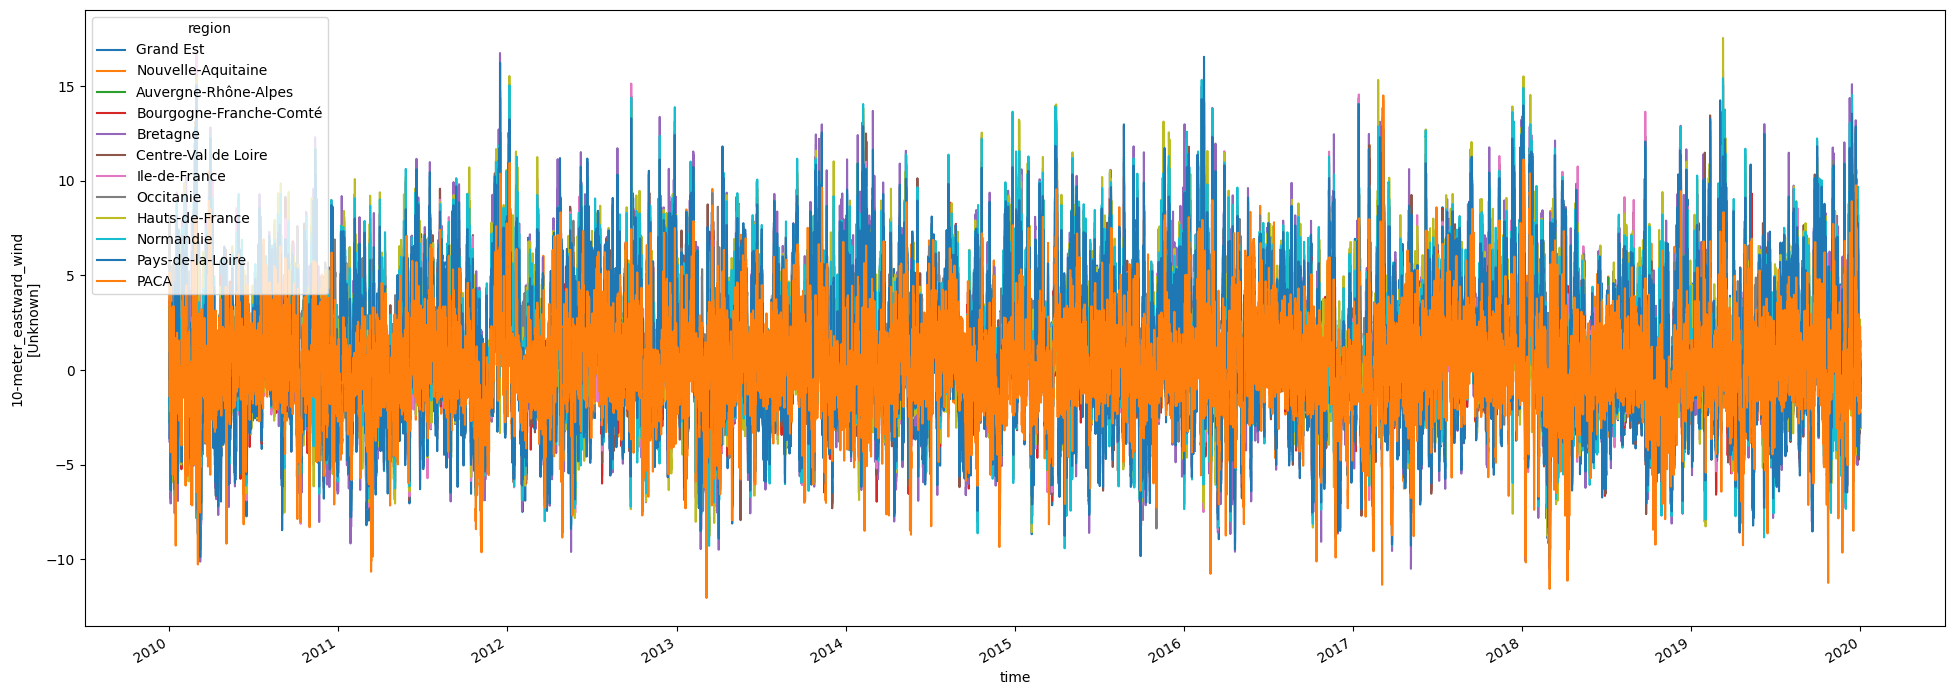

<Figure size 640x480 with 0 Axes>

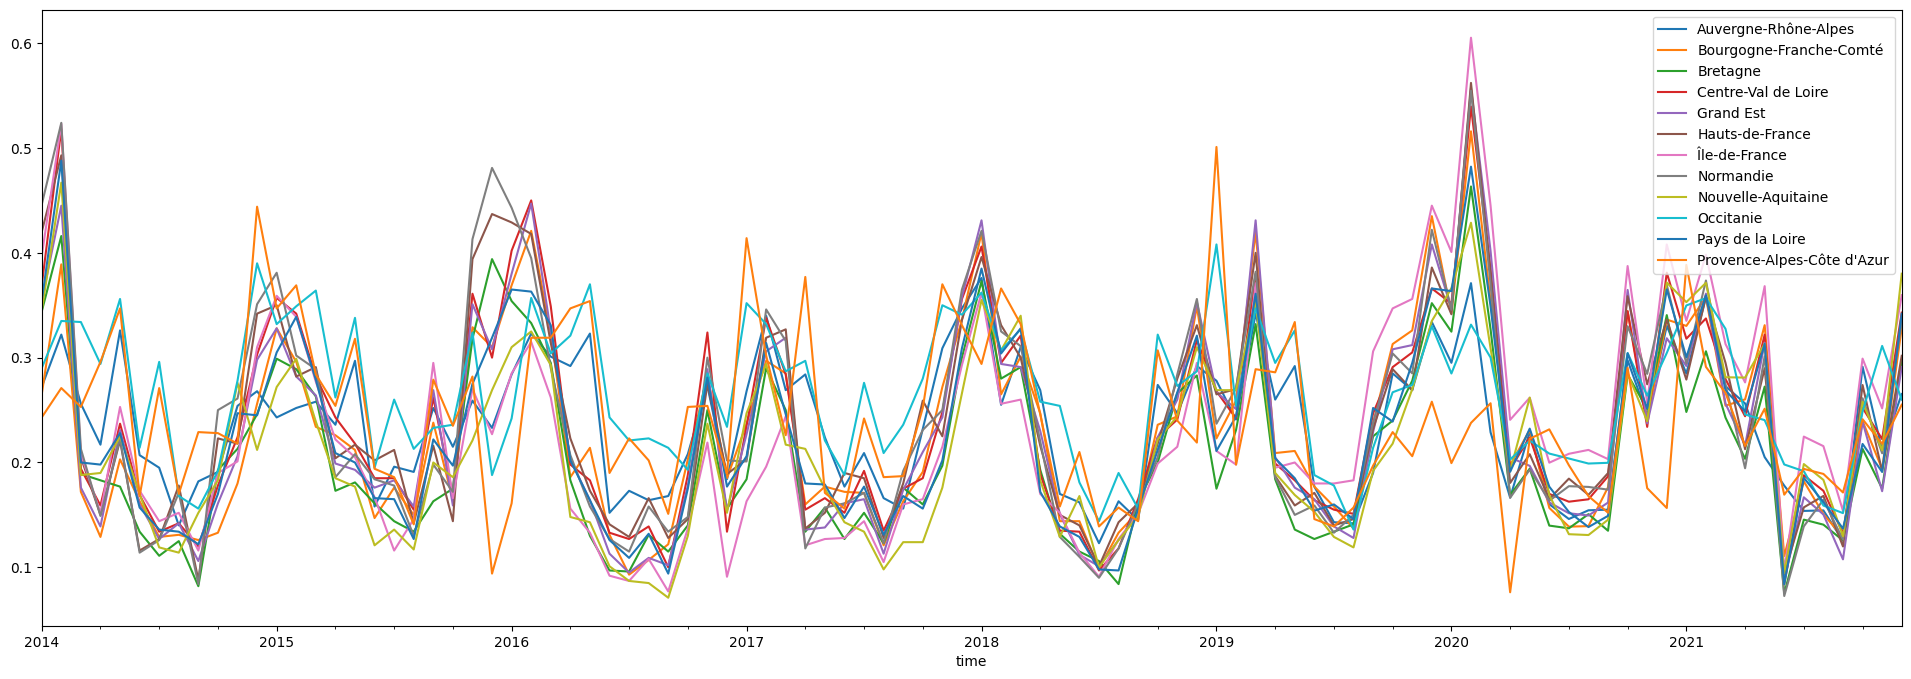

In [ ]:
# Directories where you saved the data
data_dir_energy = Path('data/projects/energy_france')
data_dir_climate = Path('data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)   
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure(figsize=(24,8))
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot(figsize=(24,8))

### Selecting a location in metropolitan France and accessing climate variables of this location

In [2]:
ds_mask = xr.load_dataset(data_dir_climate / filename_mask)
da_mask = ds_mask['mask']

variables = [
    'zonal_wind',
    'meridional_wind',
    'surface_temperature',
    'surface_downward_radiation',
    'surface_density',
    'surface_specific_humidity',
    'upper_zonal_wind',
    'upper_meridional_wind',
    'height_500',
]

In [3]:
print("Avaiable regions in France: ")
da_climate_reg.region.values 

Avaiable regions in France: 


array(['Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Ile-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
       'Pays-de-la-Loire', 'PACA'], dtype=object)

#### Selecting a region

In [4]:
region_name = 'Ile-de-France'

In [5]:
dfs = []

for var in variables:
    ds_var = xr.load_dataset(data_dir_climate / filename_climate.format(var))
    da_var = ds_var[var]                               # (time, lat, lon)

    da_var_reg = da_var.groupby(da_mask).mean().rename(mask='region')
    da_var_reg['region'] = ds_mask['region'].values    # same as prof

    # select region, convert to pandas Series, rename with variable name
    series_region = da_var_reg.sel(region=region_name).to_pandas()
    dfs.append(series_region.rename(var))

# Combine all variables side by side
df_all_variables = pd.concat(dfs, axis=1)

#df_all_variables.head()

In [6]:
#df_energy['Île-de-France'].head()

#### Taking the monthly mean of the climate variables

In [7]:
df_climate_monthly = df_all_variables.resample('MS').mean()
df_climate_monthly

zonal_wind  meridional_wind  surface_temperature   
time                                                           
2010-01-01    0.113088        -0.318379           272.273590  \
2010-02-01    1.520094         1.633788           275.193329   
2010-03-01    0.139313         0.279691           278.706116   
2010-04-01   -0.329032        -0.835640           283.016418   
2010-05-01    0.289953        -2.414946           284.744049   
...                ...              ...                  ...   
2019-08-01    1.408895         0.461117           293.096375   
2019-09-01    1.105618        -0.042446           289.145721   
2019-10-01    1.522698         1.881359           285.335632   
2019-11-01    0.918626         2.672322           279.728241   
2019-12-01    2.141349         2.515921           278.615326   

            surface_downward_radiation  surface_density   
time                                                      
2010-01-01                   43.559608         1.277740  \
2010-02-01                   71.057159         1.250808   
2010-03-01                  141.006073         1.250952   
2010-04-01                  226.640015         1.233363   
2010-05-01                  260.374359         1.221154   
...                                ...              ...   
2019-08-01                  228.612228         1.186036   
2019-09-01                  190.179108         1.206204   
2019-10-01                   93.818886         1.215386   
2019-11-01                   48.923908         1.228295   
2019-12-01                   37.618202         1.245724   

            surface_specific_humidity  upper_zonal_wind   
time                                                      
2010-01-01                   0.003301          0.350395  \
2010-02-01                   0.004014          2.226946   
2010-03-01                   0.004432          0.289097   
2010-04-01                   0.005089         -0.499806   
2010-05-01                   0.006000          0.313585   
...                               ...               ...   
2019-08-01                   0.008507          1.932217   
2019-09-01                   0.007319          1.497324   
2019-10-01                   0.007387          2.270087   
2019-11-01                   0.005679          1.407306   
2019-12-01                   0.005210          3.005750   

            upper_meridional_wind   height_500  
time                                            
2010-01-01              -0.394260  5431.350586  
2010-02-01               2.338912  5351.853027  
2010-03-01               0.467306  5505.052246  
2010-04-01              -1.213971  5592.165039  
2010-05-01              -3.403135  5595.019531  
...                           ...          ...  
2019-08-01               0.466144  5764.394531  
2019-09-01              -0.181627  5749.764648  
2019-10-01               2.770181  5654.728027  
2019-11-01               3.663819  5430.588867  
2019-12-01               3.539479  5551.990234  

[120 rows x 9 columns]

#### Overlaping data of CP and climate variables

In [8]:
df_climate_overlap = df_climate_monthly.loc['2014-01-01':'2019-12-01']
cf_overlap = df_energy['Île-de-France'].loc['2014-01-01':'2019-12-01']
cf_overlap = cf_overlap.rename('capacity_factor')
df_climate_overlap


zonal_wind  meridional_wind  surface_temperature   
time                                                           
2014-01-01    1.457212         3.932577           278.326843  \
2014-02-01    2.368809         4.987933           278.731354   
2014-03-01    0.433149         0.747019           281.533936   
2014-04-01    0.240969         0.179756           284.320435   
2014-05-01    1.160403         0.544363           285.875427   
...                ...              ...                  ...   
2019-08-01    1.408895         0.461117           293.096375   
2019-09-01    1.105618        -0.042446           289.145721   
2019-10-01    1.522698         1.881359           285.335632   
2019-11-01    0.918626         2.672322           279.728241   
2019-12-01    2.141349         2.515921           278.615326   

            surface_downward_radiation  surface_density   
time                                                      
2014-01-01                   35.078514         1.239541  \
2014-02-01                   66.375504         1.236099   
2014-03-01                  150.002029         1.237386   
2014-04-01                  203.017075         1.222223   
2014-05-01                  242.731064         1.216665   
...                                ...              ...   
2019-08-01                  228.612228         1.186036   
2019-09-01                  190.179108         1.206204   
2019-10-01                   93.818886         1.215386   
2019-11-01                   48.923908         1.228295   
2019-12-01                   37.618202         1.245724   

            surface_specific_humidity  upper_zonal_wind   
time                                                      
2014-01-01                   0.005184          2.201479  \
2014-02-01                   0.004937          3.462634   
2014-03-01                   0.004942          0.462770   
2014-04-01                   0.006059          0.329754   
2014-05-01                   0.006797          1.622033   
...                               ...               ...   
2019-08-01                   0.008507          1.932217   
2019-09-01                   0.007319          1.497324   
2019-10-01                   0.007387          2.270087   
2019-11-01                   0.005679          1.407306   
2019-12-01                   0.005210          3.005750   

            upper_meridional_wind   height_500  
time                                            
2014-01-01               5.413025  5441.876465  
2014-02-01               6.872248  5407.690918  
2014-03-01               1.120855  5576.235352  
2014-04-01               0.195392  5591.039062  
2014-05-01               0.683228  5610.685547  
...                           ...          ...  
2019-08-01               0.466144  5764.394531  
2019-09-01              -0.181627  5749.764648  
2019-10-01               2.770181  5654.728027  
2019-11-01               3.663819  5430.588867  
2019-12-01               3.539479  5551.990234  

[72 rows x 9 columns]

In [9]:
cf_overlap

time
2014-01-01    0.397
2014-02-01    0.523
2014-03-01    0.208
2014-04-01    0.152
2014-05-01    0.253
              ...  
2019-08-01    0.183
2019-09-01    0.306
2019-10-01    0.347
2019-11-01    0.356
2019-12-01    0.445
Name: capacity_factor, Length: 72, dtype: float64

In [10]:
df_dataset = df_climate_overlap.copy()
df_dataset['capacity_factor'] = cf_overlap
df_dataset = df_climate_overlap.join(cf_overlap, how='inner')
#df_dataset.head()

#### Evaluating linear correlation between the climate variables and CP value

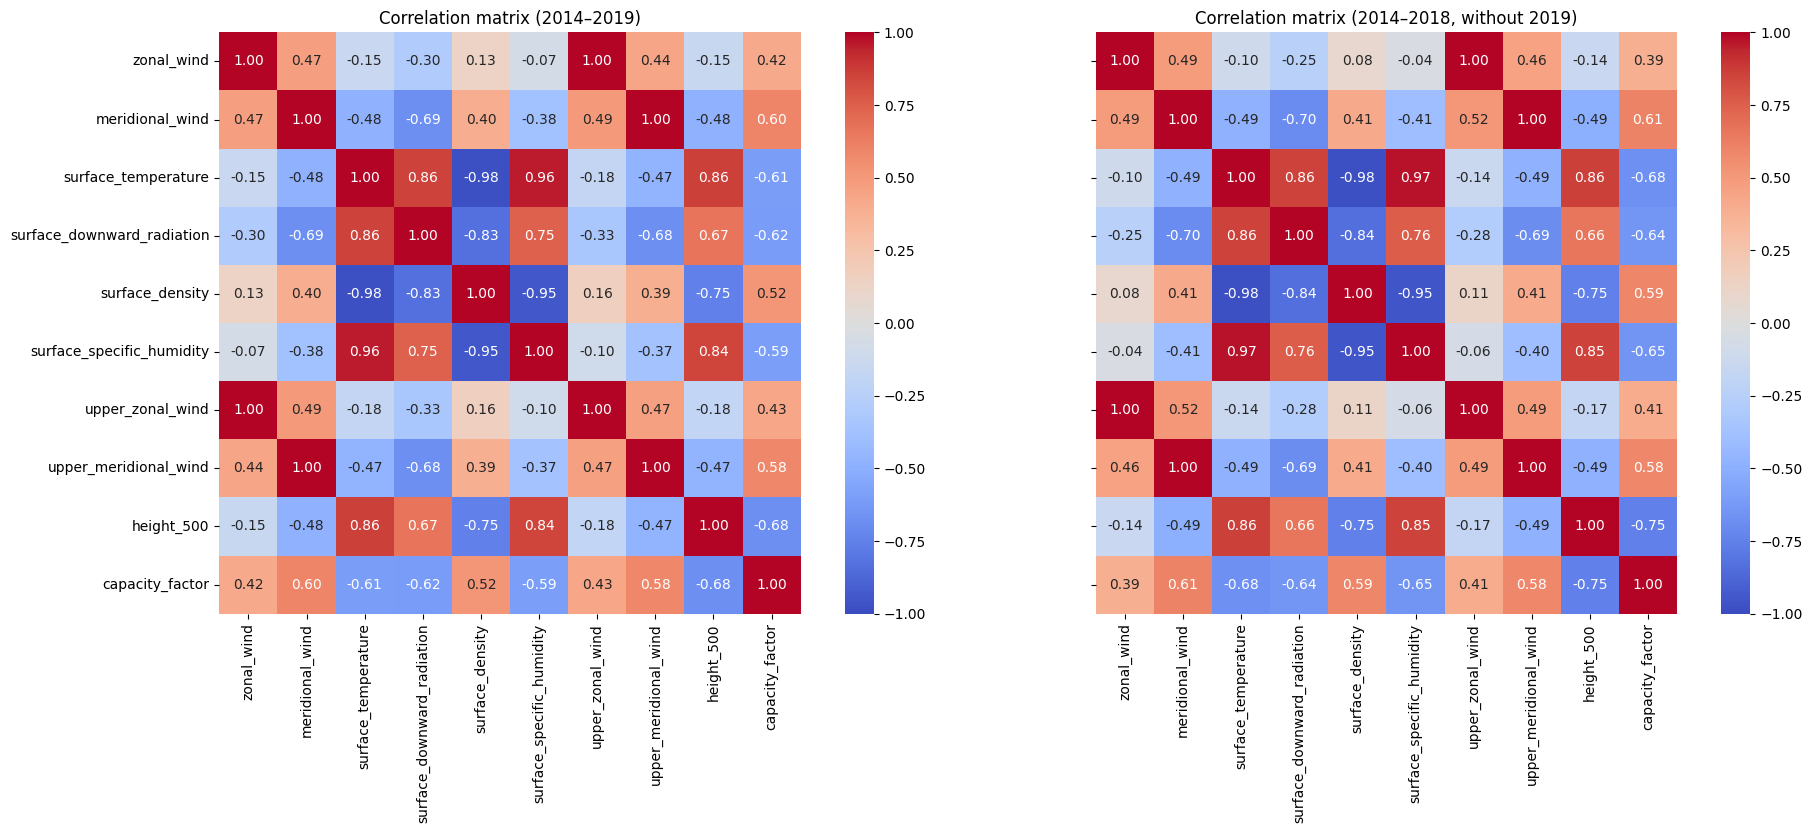

In [ ]:
corr_all = df_dataset.corr()

df_climate_overlap = df_climate_monthly.loc['2014-01-01':'2018-12-01']
cf_overlap = df_energy['Île-de-France'].loc['2014-01-01':'2018-12-01']
cf_overlap = cf_overlap.rename('capacity_factor')

df_dataset_no2019 = df_climate_overlap.join(cf_overlap, how='inner')
corr_no2019 = df_dataset_no2019.corr()



fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.heatmap(
    corr_all,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    vmin=-1,
    vmax=1,
    ax=axes[0]
)
axes[0].set_title("Correlation matrix (2014–2019)")

sns.heatmap(
    corr_no2019,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    vmin=-1,
    vmax=1,
    ax=axes[1]
)
axes[1].set_title("Correlation matrix (2014–2018, without 2019)")

plt.tight_layout()
plt.show()

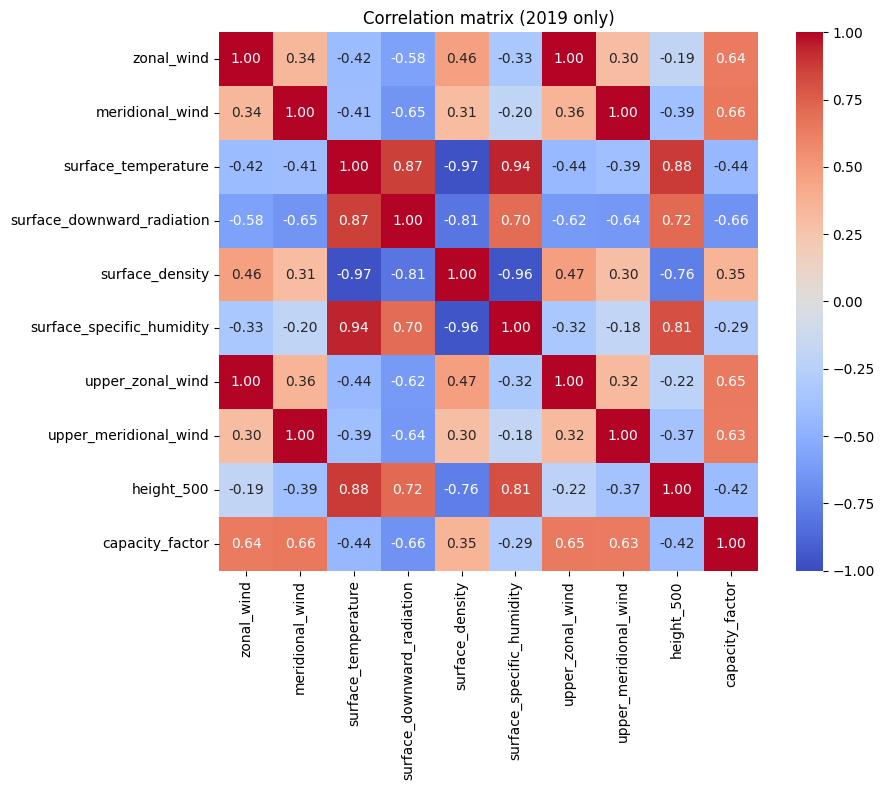

In [123]:
# Selecionar apenas o ano de 2019
df_climate_2019 = df_climate_monthly.loc['2019-01-01':'2019-12-01']
cf_2019 = df_energy['Île-de-France'].loc['2019-01-01':'2019-12-01']
cf_2019 = cf_2019.rename('capacity_factor')

# Construir dataset final de 2019
df_dataset_2019 = df_climate_2019.join(cf_2019, how='inner')

# Matriz de correlação
corr_2019 = df_dataset_2019.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_2019,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    vmin=-1,
    vmax=1
)
plt.title("Correlation matrix (2019 only)")
plt.tight_layout()
plt.show()


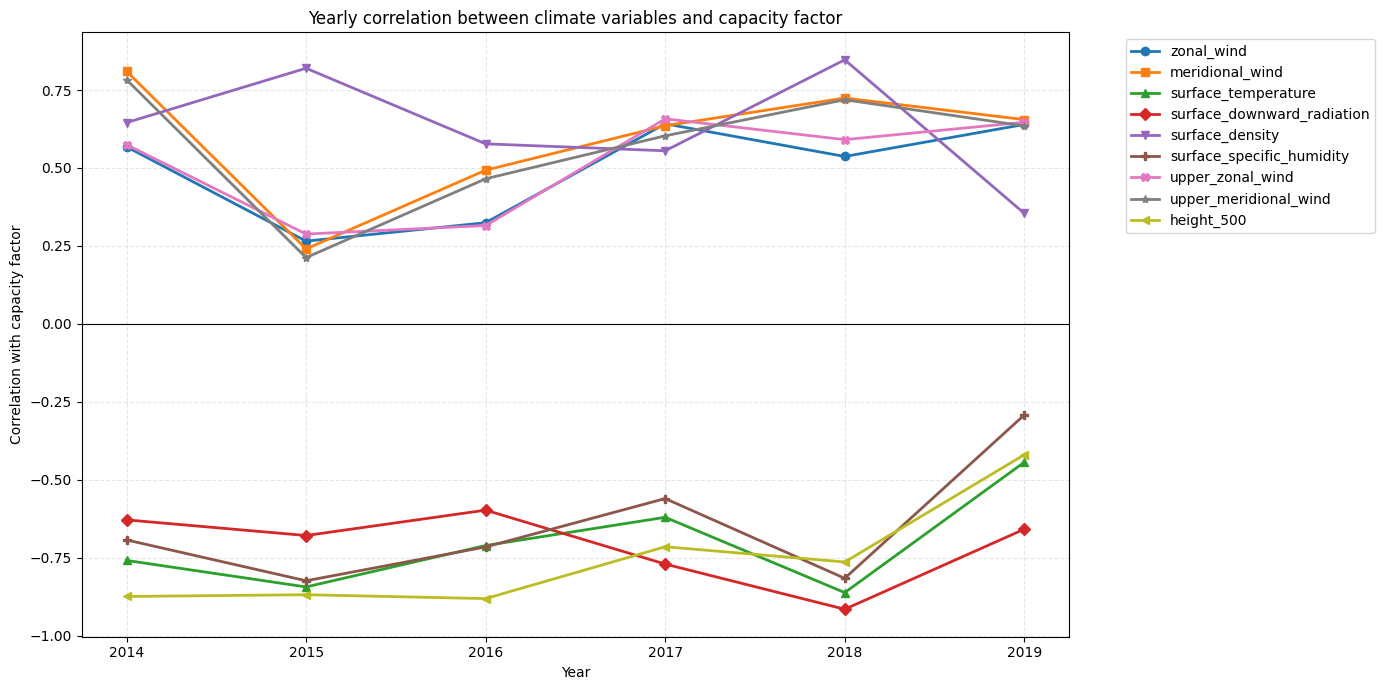

In [ ]:
# Dataset completo (2014–2019)
df = df_dataset.sort_index().copy()

# Variáveis climáticas
climate_vars = df.columns.drop("capacity_factor")

# Anos
years = df.index.year.unique()

# DataFrame para armazenar correlações
corr_by_year = pd.DataFrame(index=years, columns=climate_vars, dtype=float)

# Calcular correlações ano a ano
for year in years:
    df_year = df.loc[str(year)]
    for var in climate_vars:
        corr_by_year.loc[year, var] = df_year[var].corr(df_year["capacity_factor"])

# --- estilos ---
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', '<', '>']

style_cycle = itertools.product(line_styles, markers)

# Plot
plt.figure(figsize=(14, 7))

for var, (ls, mk) in zip(climate_vars, style_cycle):
    plt.plot(
        corr_by_year.index,
        corr_by_year[var],
        linestyle=ls,
        marker=mk,
        linewidth=2,
        markersize=6,
        label=var
    )

plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Year")
plt.ylabel("Correlation with capacity factor")
plt.title("Yearly correlation between climate variables and capacity factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


According to the last column values we can see that the lesser linearly correlated variable has a value of 0.42 which does not indicate a very weak correlation. 

#### Data viewing

#### All time - CP

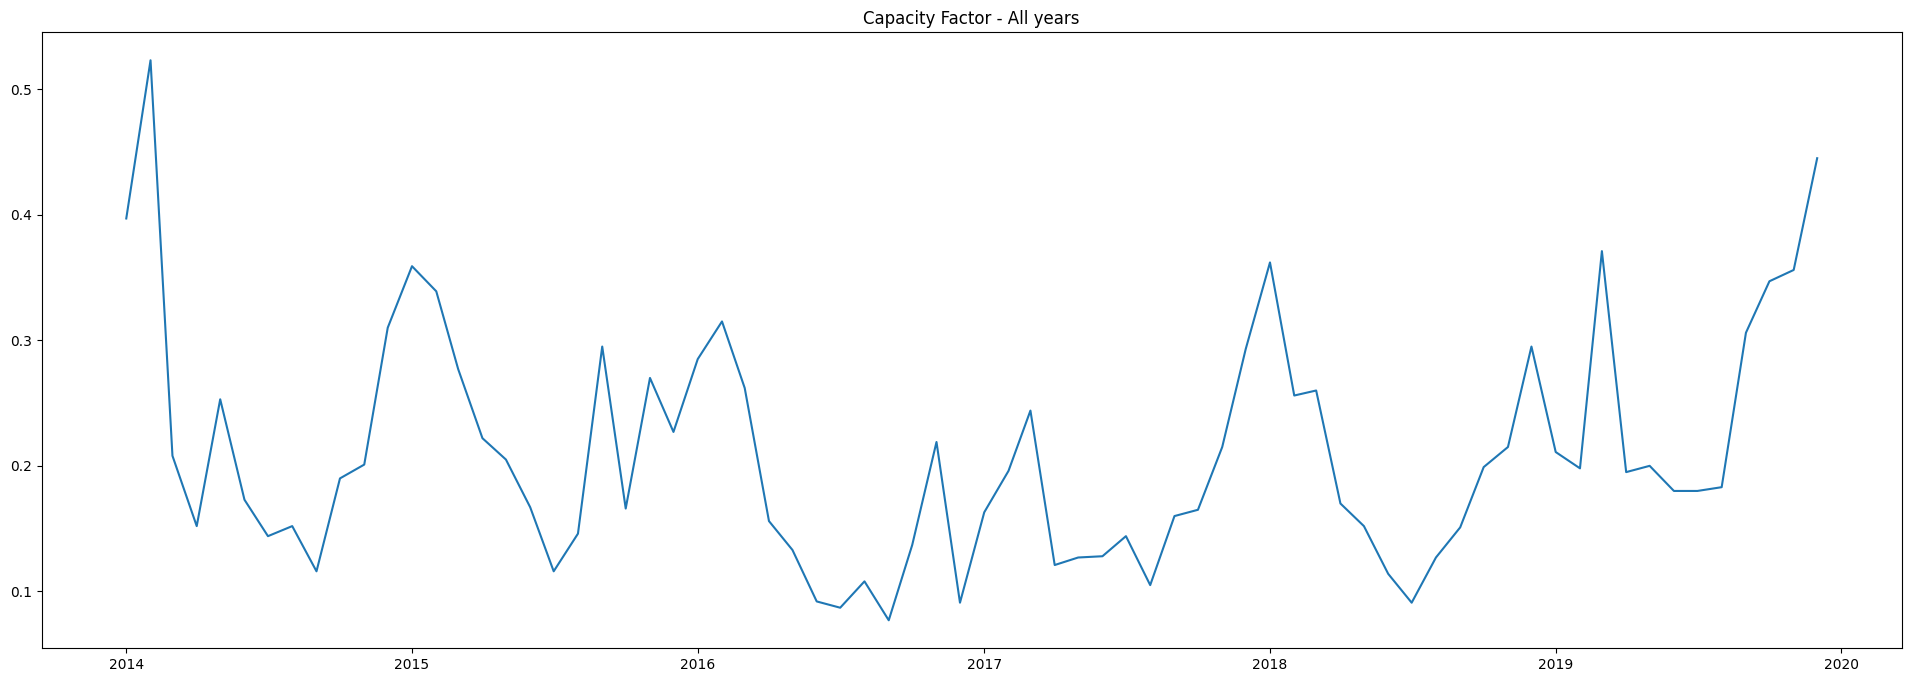

In [14]:
plt.figure(figsize=(24,8))
plt.plot(cf_overlap)
plt.title("Capacity Factor - All years")
plt.show()

a seasonality is well expected and can be identified, where the cp increase on the winters and decrease at the summers.

#### Years superposed

#### CP

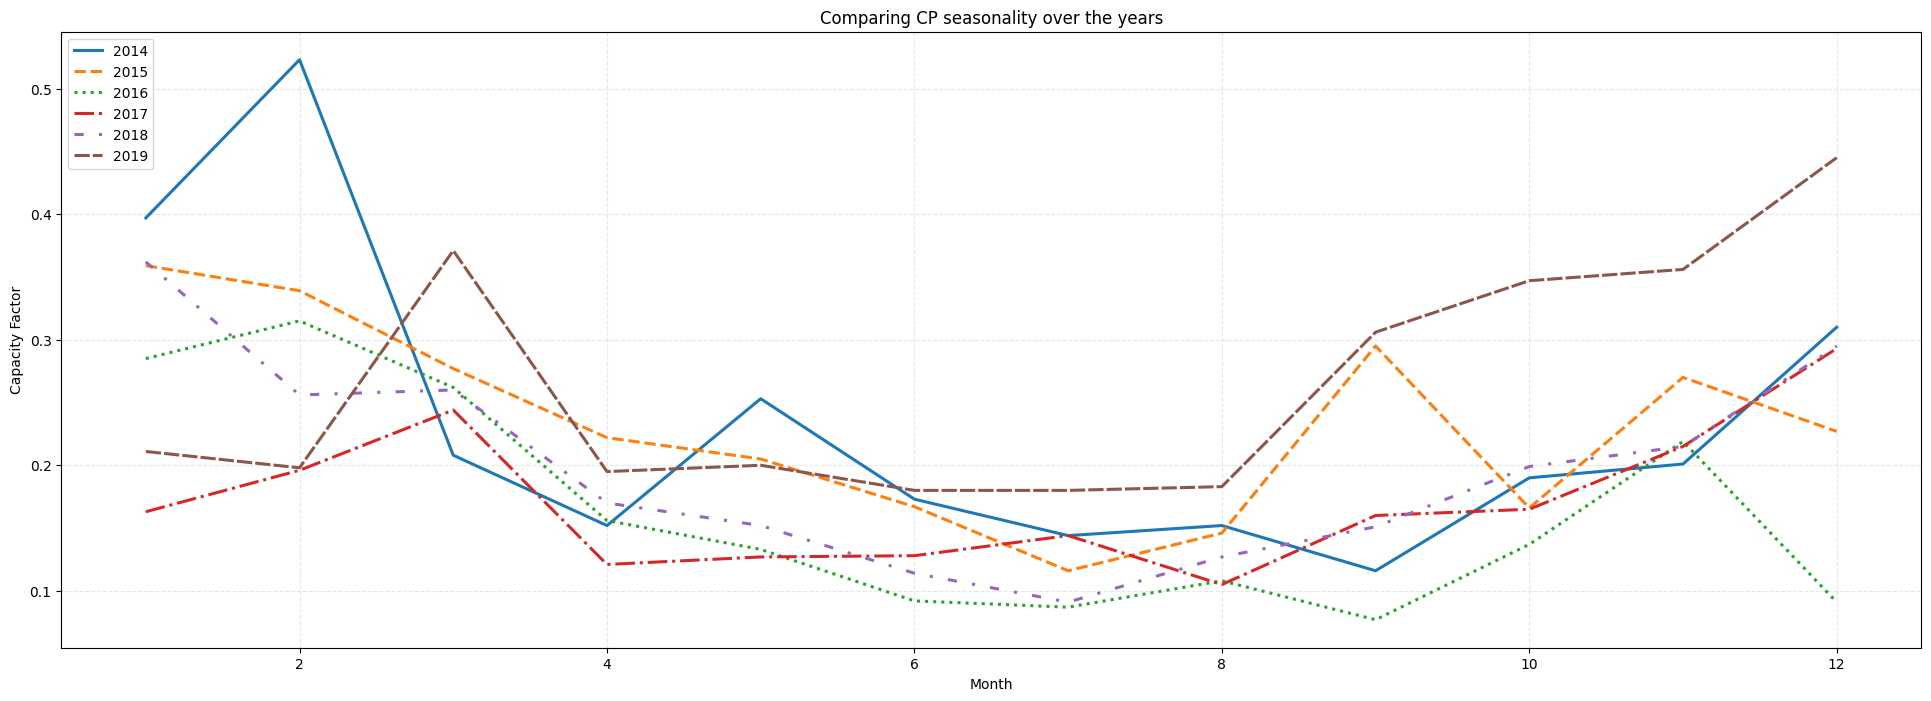

In [15]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',       
    '--',      
    ':',     
    '-.',     
    (0, (3, 5, 1, 5)), 
    (0, (5, 1))         
]

years = cf_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = cf_overlap[str(year)]
    ls = line_styles[i % len(line_styles)]   # repete padrões se tiver mais de 6 anos
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("Capacity Factor")
plt.title("Comparing CP seasonality over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


our data set provides us with 6 years of monthly data, which are represented above. we can identify a seaonality with the increase of cp values at winter and decrease at summer, but also there are some discrepancies between the majority of cp data, like it was seen in 2014, when we had a peak of cp in february and a smaller one in may, and specially in 2019, when we saw a unexpected peak in march, a constant value between april to august and then a important increase until the end of the year.

The dataset does not satisfy the iid assumption. Observations are temporally correlated due to seasonality, and the underlying distribution evolves over time, as evidenced by the poor generalization to the year 2019, which behaves as an out-of-distribution period.

#### Some climate variables

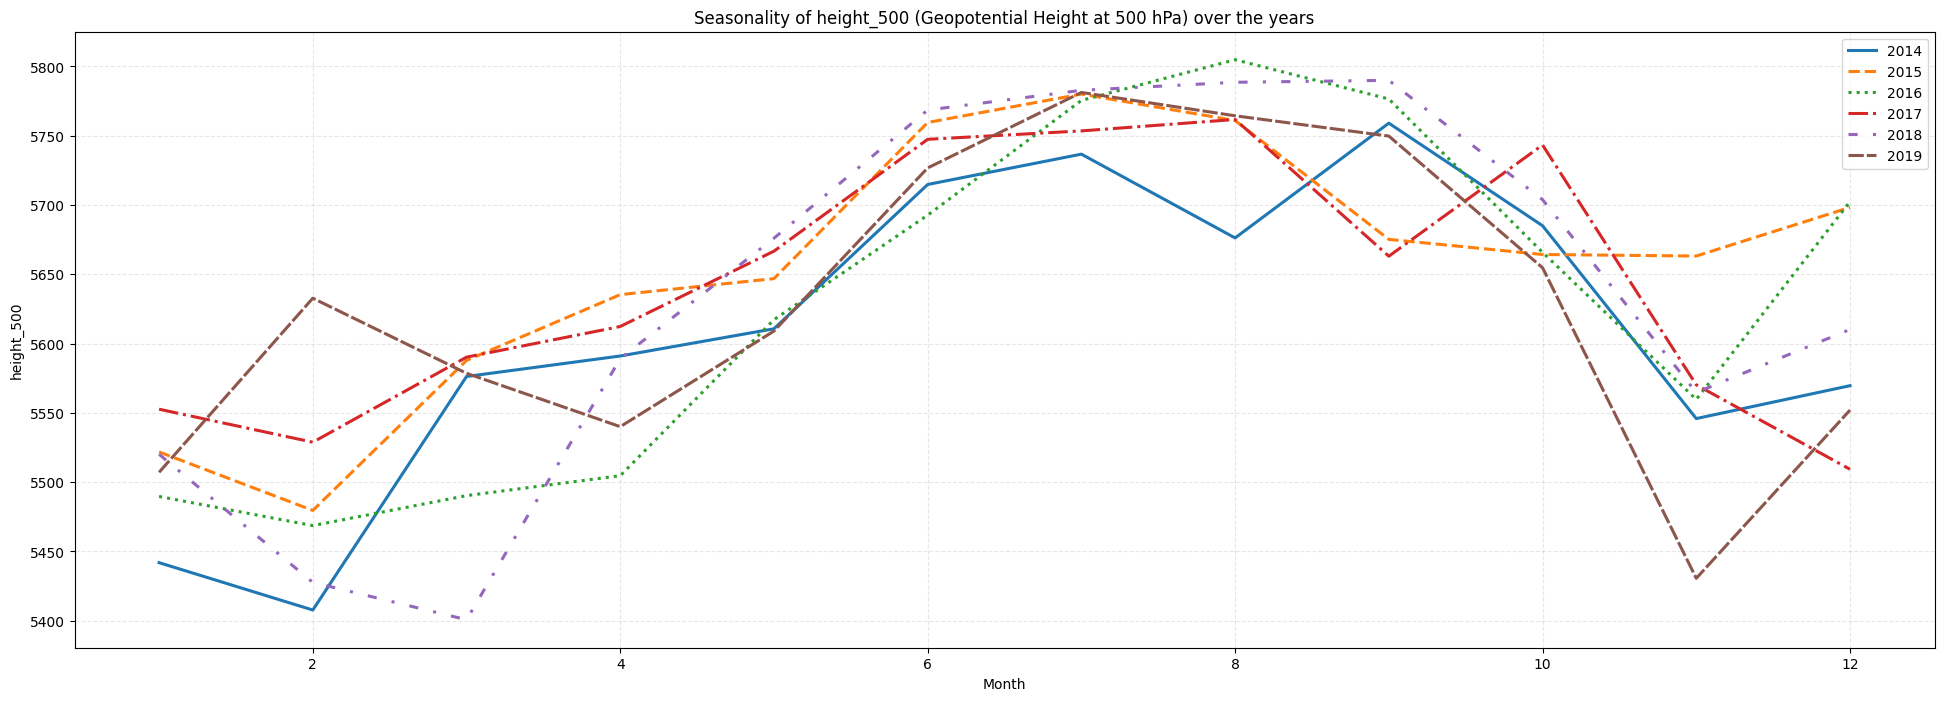

In [16]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',          
    '--',         
    ':',          
    '-.',         
    (0, (3, 5, 1, 5)),  
    (0, (5, 1))         
]


years = df_climate_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = df_climate_overlap['height_500'].loc[str(year)]
    ls = line_styles[i % len(line_styles)]
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("height_500")
plt.title("Seasonality of height_500 (Geopotential Height at 500 hPa) over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


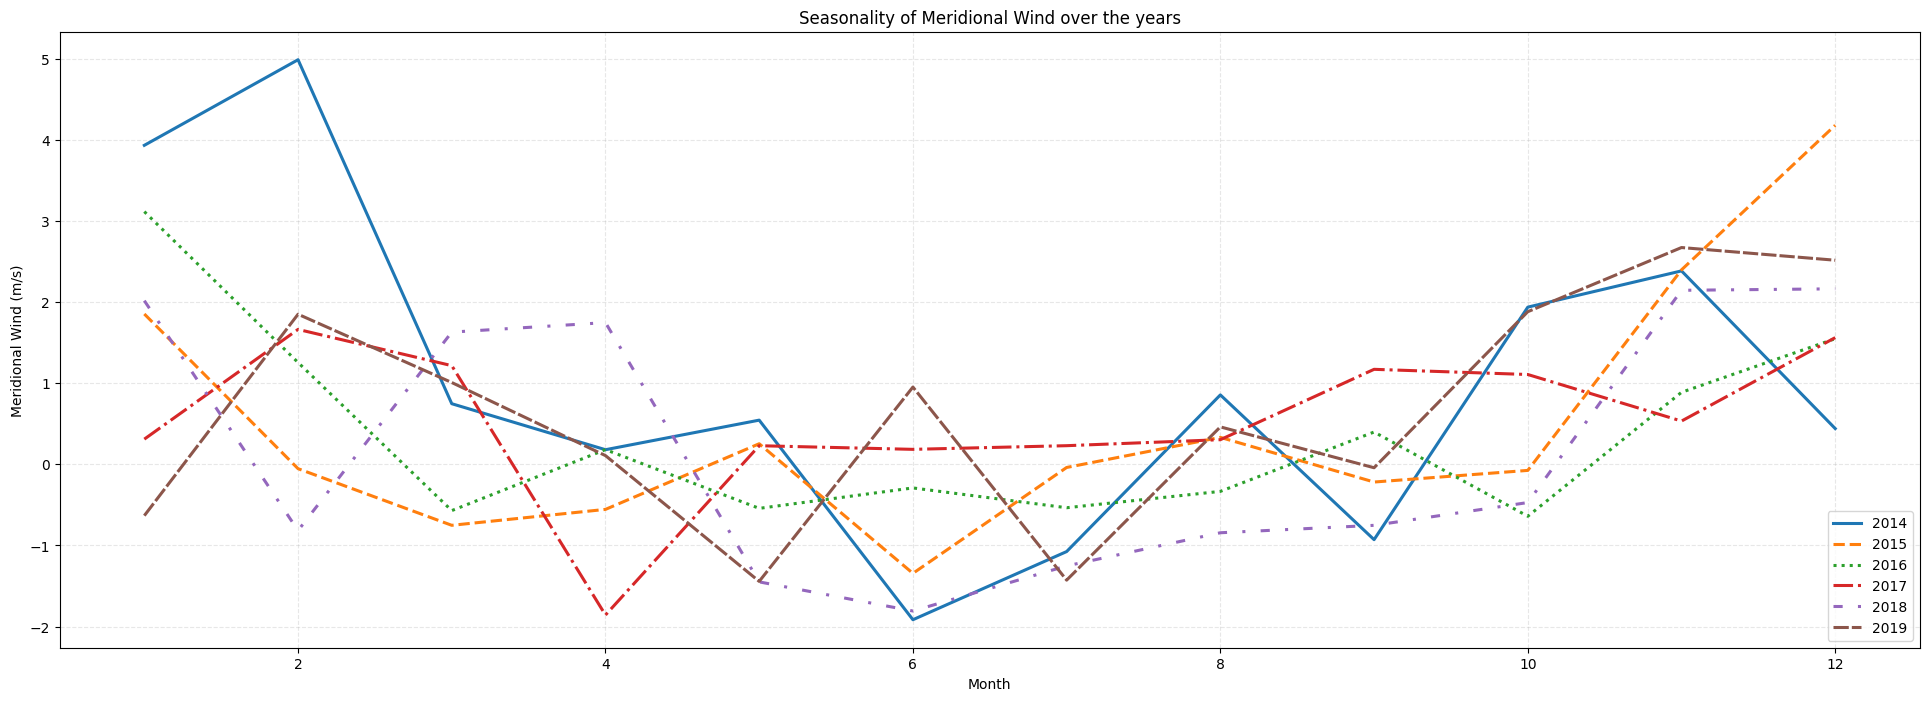

In [19]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',          
    '--',         
    ':',          
    '-.',         
    (0, (3, 5, 1, 5)),  
    (0, (5, 1))         
]

years = df_climate_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = df_climate_overlap['meridional_wind'].loc[str(year)]
    ls = line_styles[i % len(line_styles)]
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("Meridional Wind (m/s)")
plt.title("Seasonality of Meridional Wind over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


## 1. Linear Regression

We consider a linear regression model of the form:

$$
\hat{y} = X\beta + b
$$

where:

* **(X)** is the matrix of input features
* **(y)** is the target vector
* **$\hat{y}$** is the model prediction
* **$\beta$** is the vector of **model coefficients**, representing the contribution of each feature
* **(b)** is the intercept term

## **2. Loss Functions for Each Model**

### **2.1 Ordinary Least Squares (OLS)**

OLS minimizes the **sum of squared errors**:

$$
\min_{\beta} ; |y - X\beta|_2^2
$$

This corresponds to finding the coefficients that best fit the data.

## Linear regression

#### Testing more recent data performance when training the linear regression model

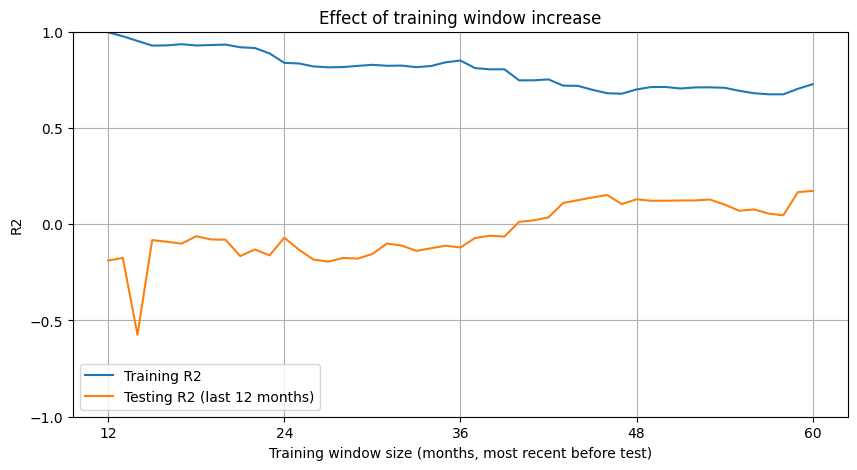

In [50]:
df = df_dataset.copy()       
df = df.sort_index()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values

n_samples = len(df)
test_size = 12                    # últimos 2 meses como teste
test_start = n_samples - test_size 

n_train_max = test_start         

R2_train = np.zeros(n_train_max + 1)
R2_test  = np.zeros(n_train_max + 1)

for i in range(12, n_train_max + 1):

    train_start = test_start - i
    train_end   = test_start

    X_train_raw = X_full[train_start:train_end, :]
    y_train = y_full[train_start:train_end]

    X_test_raw  = X_full[test_start:, :]
    y_test = y_full[test_start:]

    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)

    #std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std
    X_test  = (X_test_raw  - mean) / std

    model = LinearRegression().fit(X_train, y_train)

    R2_train[i] = model.score(X_train, y_train)
    R2_test[i]  = model.score(X_test, y_test)


train_sizes = np.arange(12, n_train_max + 1)

plt.figure(figsize=(10,5))
plt.plot(train_sizes, R2_train[12:], label='Training R2')
plt.plot(train_sizes, R2_test[12:], label='Testing R2 (last 12 months)')
plt.xlabel('Training window size (months, most recent before test)')
plt.ylabel('R2')
plt.xticks([12, 24, 36, 48, 60])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.ylim(-1, 1)
plt.title('Effect of training window increase')
plt.legend()
plt.grid()
plt.show()

In [110]:
def plot_linear_model_with_test_window(df_in, test_size):
    """
    Train a linear regression model using all data except the last `test_size` samples,
    and plot observed vs predicted capacity factor with a fixed test window.
    
    Parameters
    ----------
    df_in : pandas.DataFrame
        Dataset containing climate variables and 'capacity_factor'
    test_size : int
        Number of samples (months) used as test window
    """

    df = df_in.sort_index().copy()

    X_full = df.drop(columns=["capacity_factor"]).values
    y_full = df["capacity_factor"].values
    time_index = df.index

    n_samples = len(df)
    n_train = n_samples - test_size

    # --- split ---
    X_train_raw = X_full[:n_train, :]
    y_train = y_full[:n_train]

    X_test_raw  = X_full[n_train:, :]
    y_test = y_full[n_train:]

    # --- normalization (train only) ---
    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)
    std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std
    X_test  = (X_test_raw  - mean) / std

    # --- model ---
    model = LinearRegression().fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # --- R² ---
    R2_test = model.score(X_test, y_test)

    # --- plot ---
    plt.figure(figsize=(24,8))

    # observed CP
    plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
    plt.plot(time_index[n_train:], y_test, 'k--')

    # predictions
    plt.plot(
        time_index[:n_train],
        y_pred_train,
        color='C0',
        linestyle='-.',
        label='Model prediction (train)'
    )

    plt.plot(
        time_index[n_train:],
        y_pred_test,
        color='C0',
        linestyle='-',
        label='Model prediction (test)'
    )

    # train / test boundary
    plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Capacity Factor")
    plt.title(
        f"Capacity factor and linear model prediction "
        f"({n_train} months train, {test_size} months test), "
        f"R² test = {R2_test:.2f}"
    )
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return R2_test

### 6months, 1 and 2 years of test - 2019 include

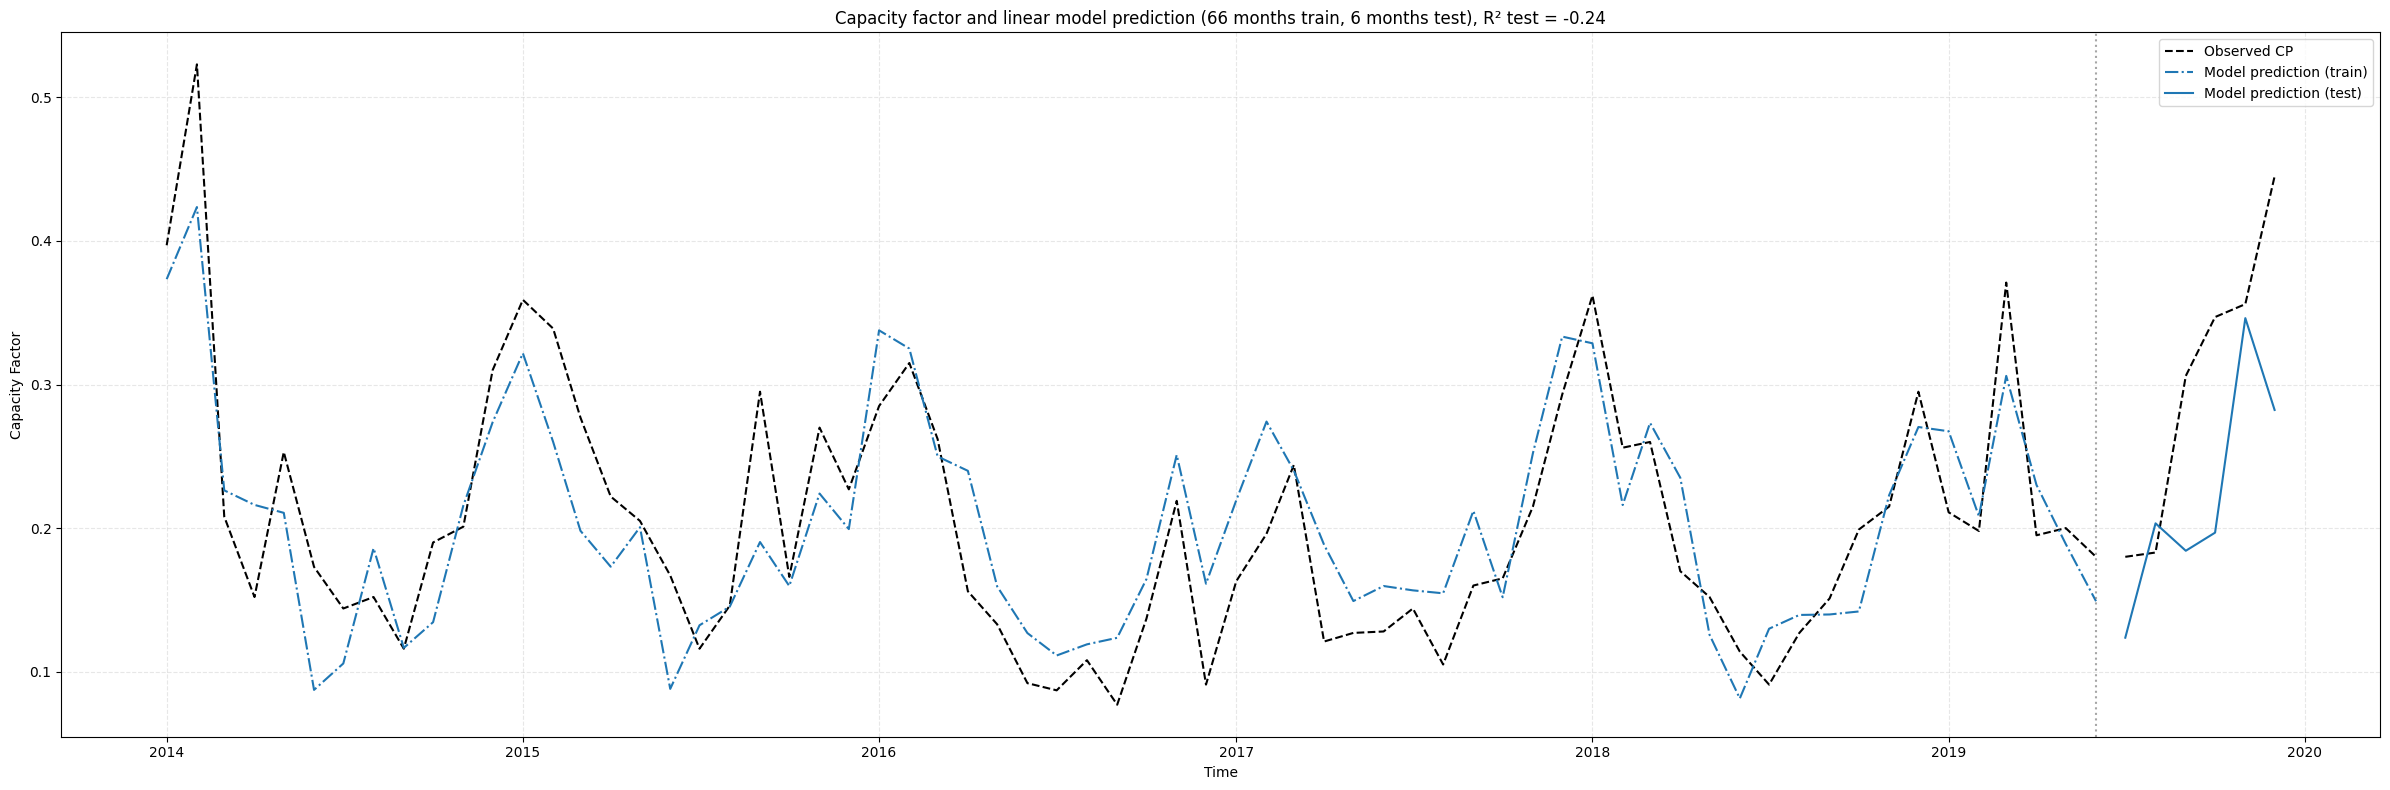

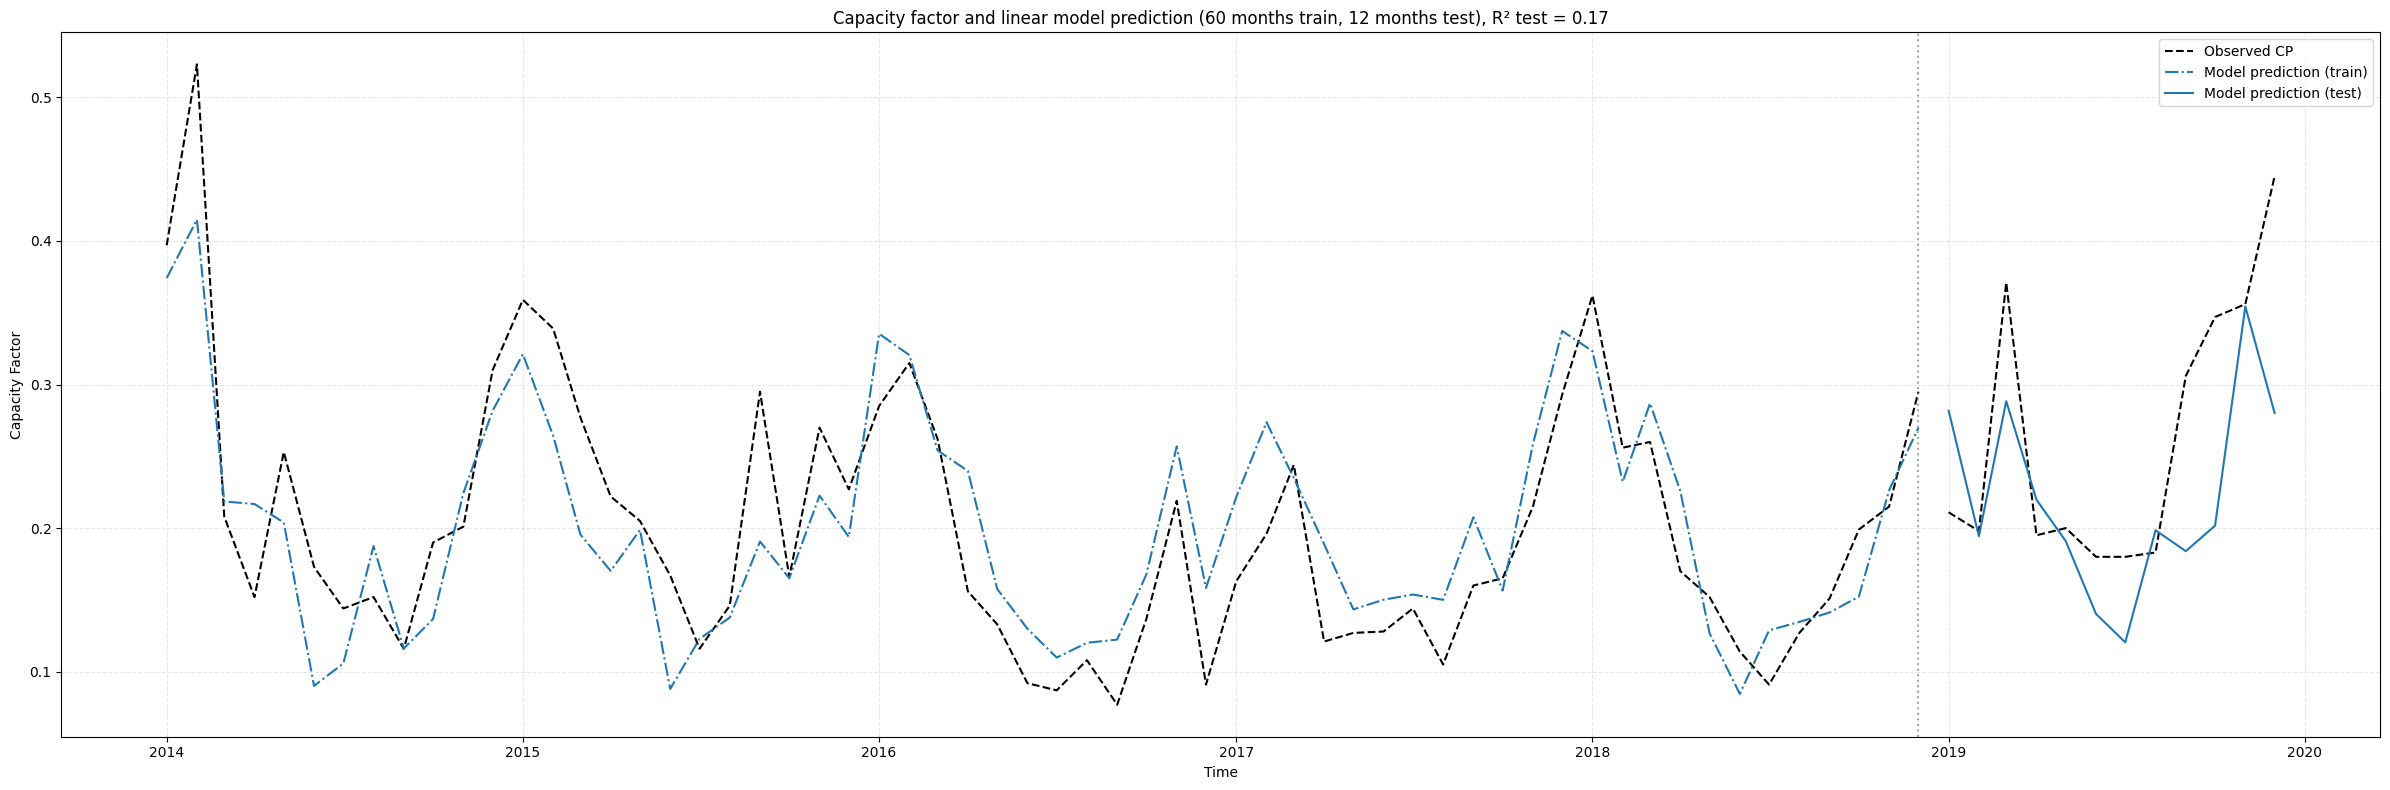

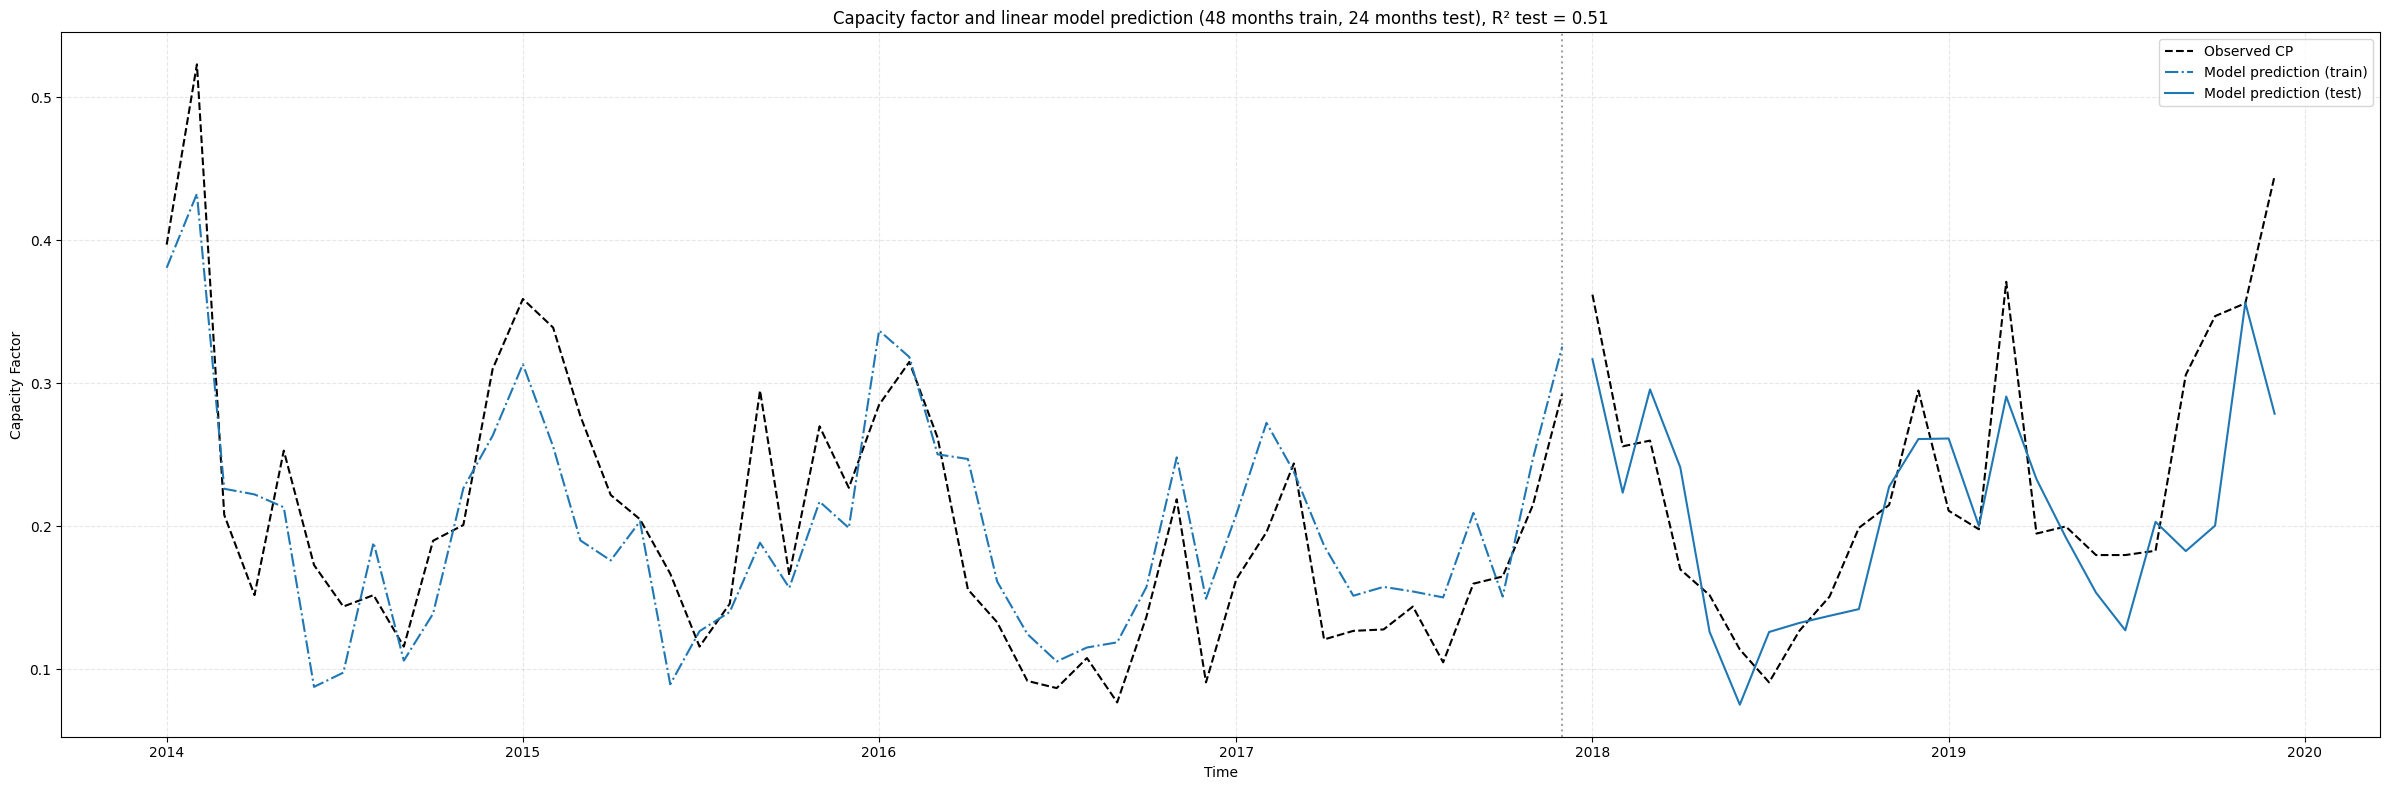

In [111]:
R2_6 = plot_linear_model_with_test_window(df_dataset, test_size=6)
R2_12 = plot_linear_model_with_test_window(df_dataset, test_size=12)
R2_24 = plot_linear_model_with_test_window(df_dataset, test_size=24)

we see an increase of R2 with the test window, which doenst mean that we have a better model, just that we were able to predict before 2019 better than that year itself.

In [116]:
df_dataset_reduced = df_dataset.drop(
    columns=["upper_zonal_wind", "upper_meridional_wind"]
)

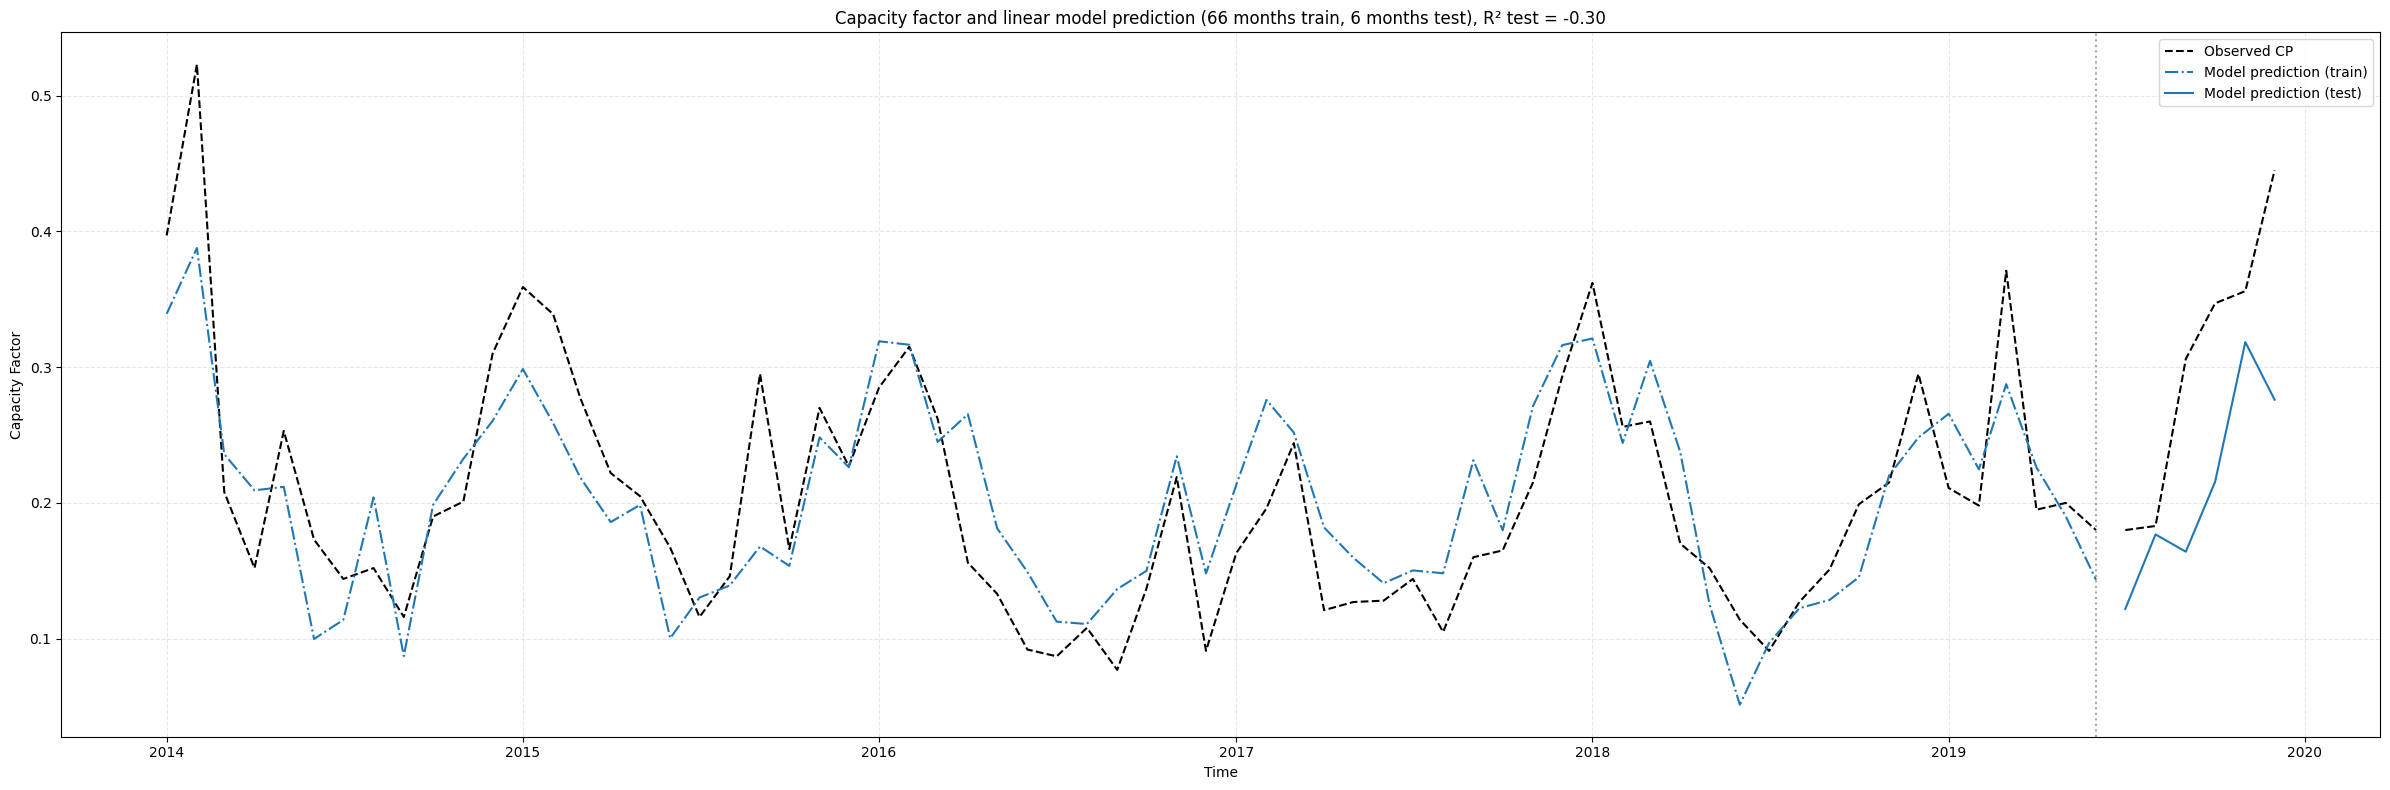

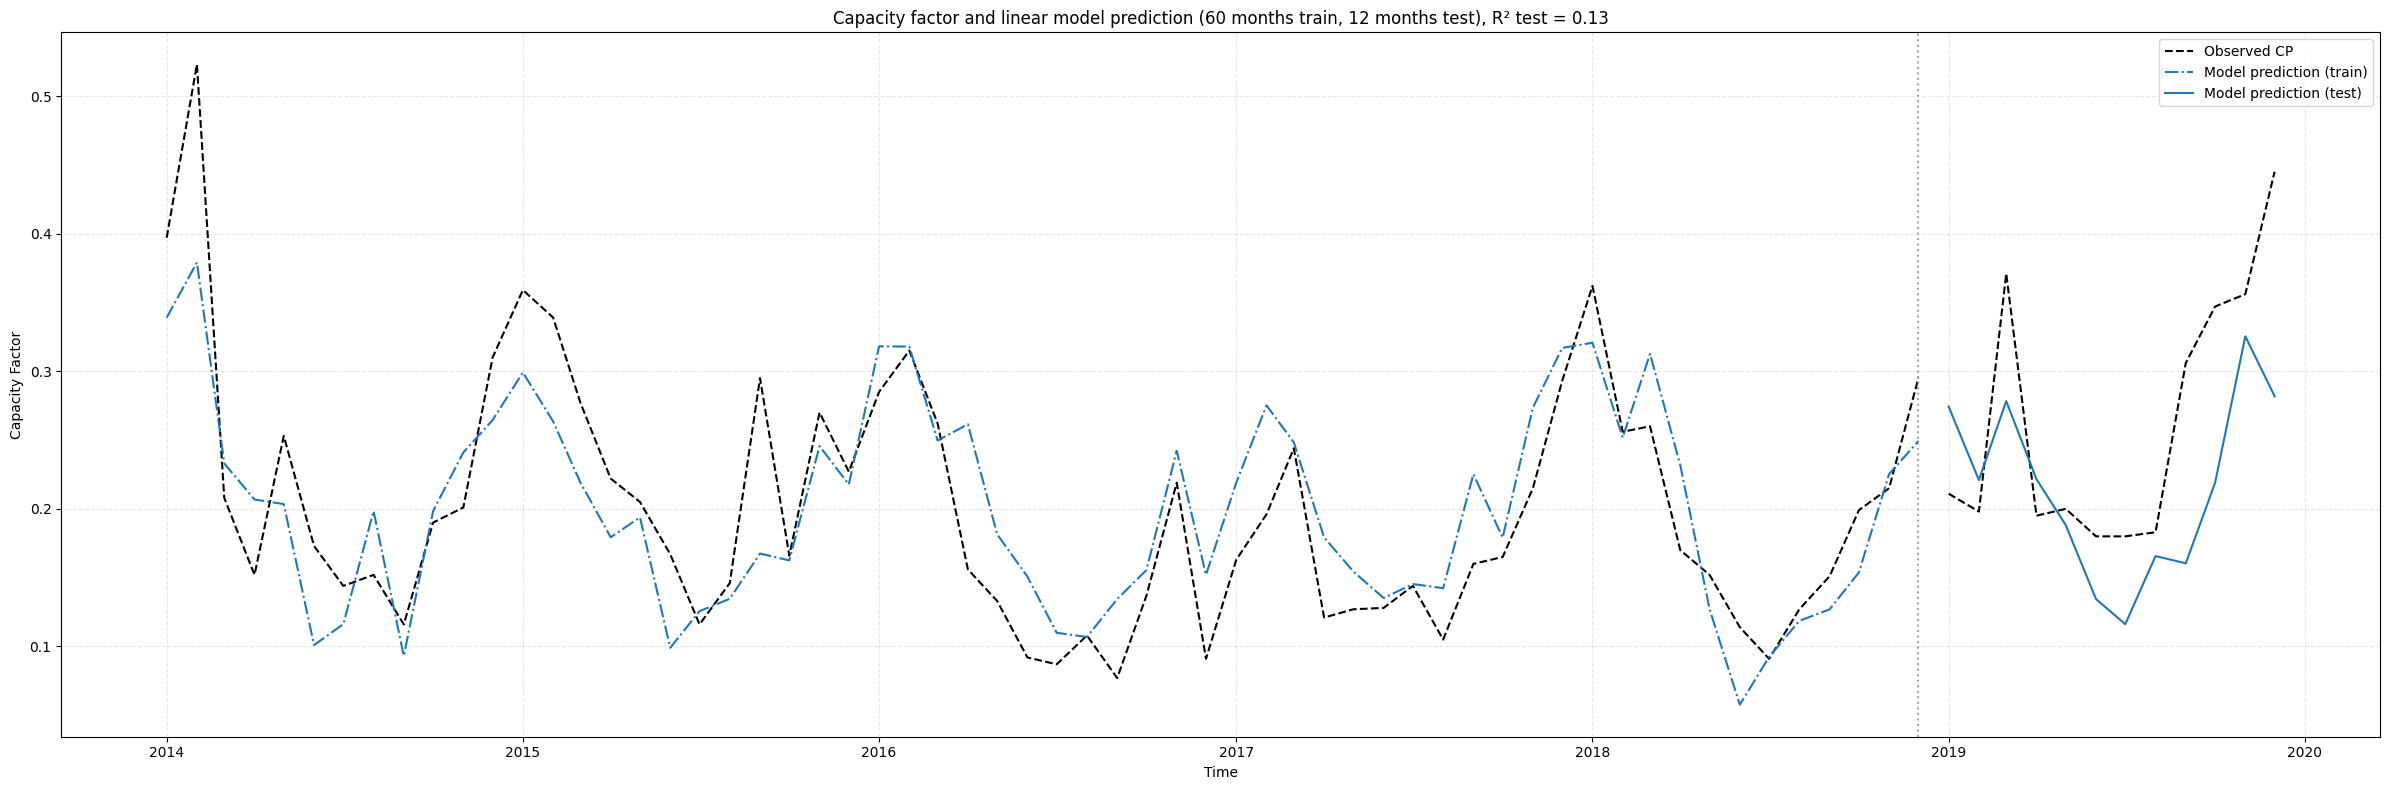

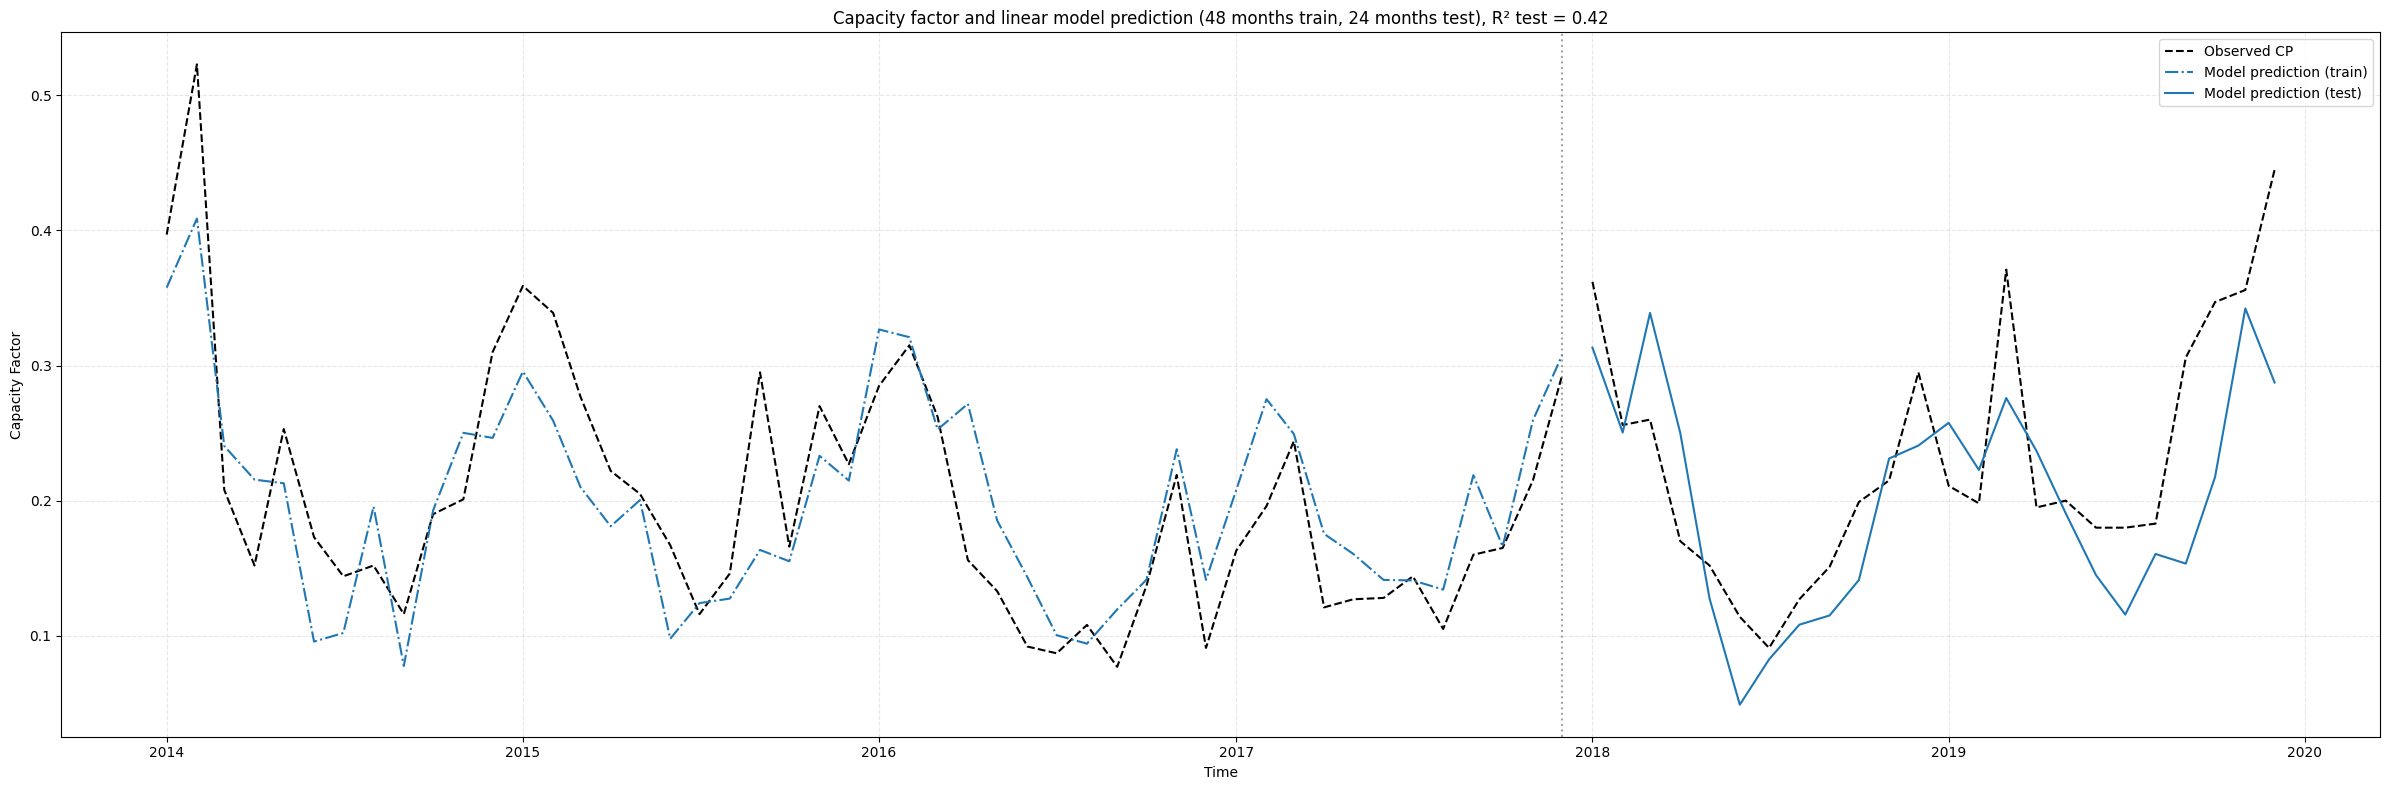

In [117]:
R2_6 = plot_linear_model_with_test_window(df_dataset_reduced, test_size=6)
R2_12 = plot_linear_model_with_test_window(df_dataset_reduced, test_size=12)
R2_24 = plot_linear_model_with_test_window(df_dataset_reduced, test_size=24)

In [ ]:
# df_no2019_reduced = df_dataset_reduced.sort_index().loc[:'2018-12-01'].copy()
# R2_6 = plot_linear_model_with_test_window(df_no2019_reduced, test_size=6)
# R2_12 = plot_linear_model_with_test_window(df_no2019_reduced, test_size=12)
# R2_24 = plot_linear_model_with_test_window(df_no2019_reduced, test_size=24)

### Analysing model performance without looking at 2019

In [105]:
df_no2019 = df_dataset.sort_index().loc[:'2018-12-01'].copy()
#df_no2019

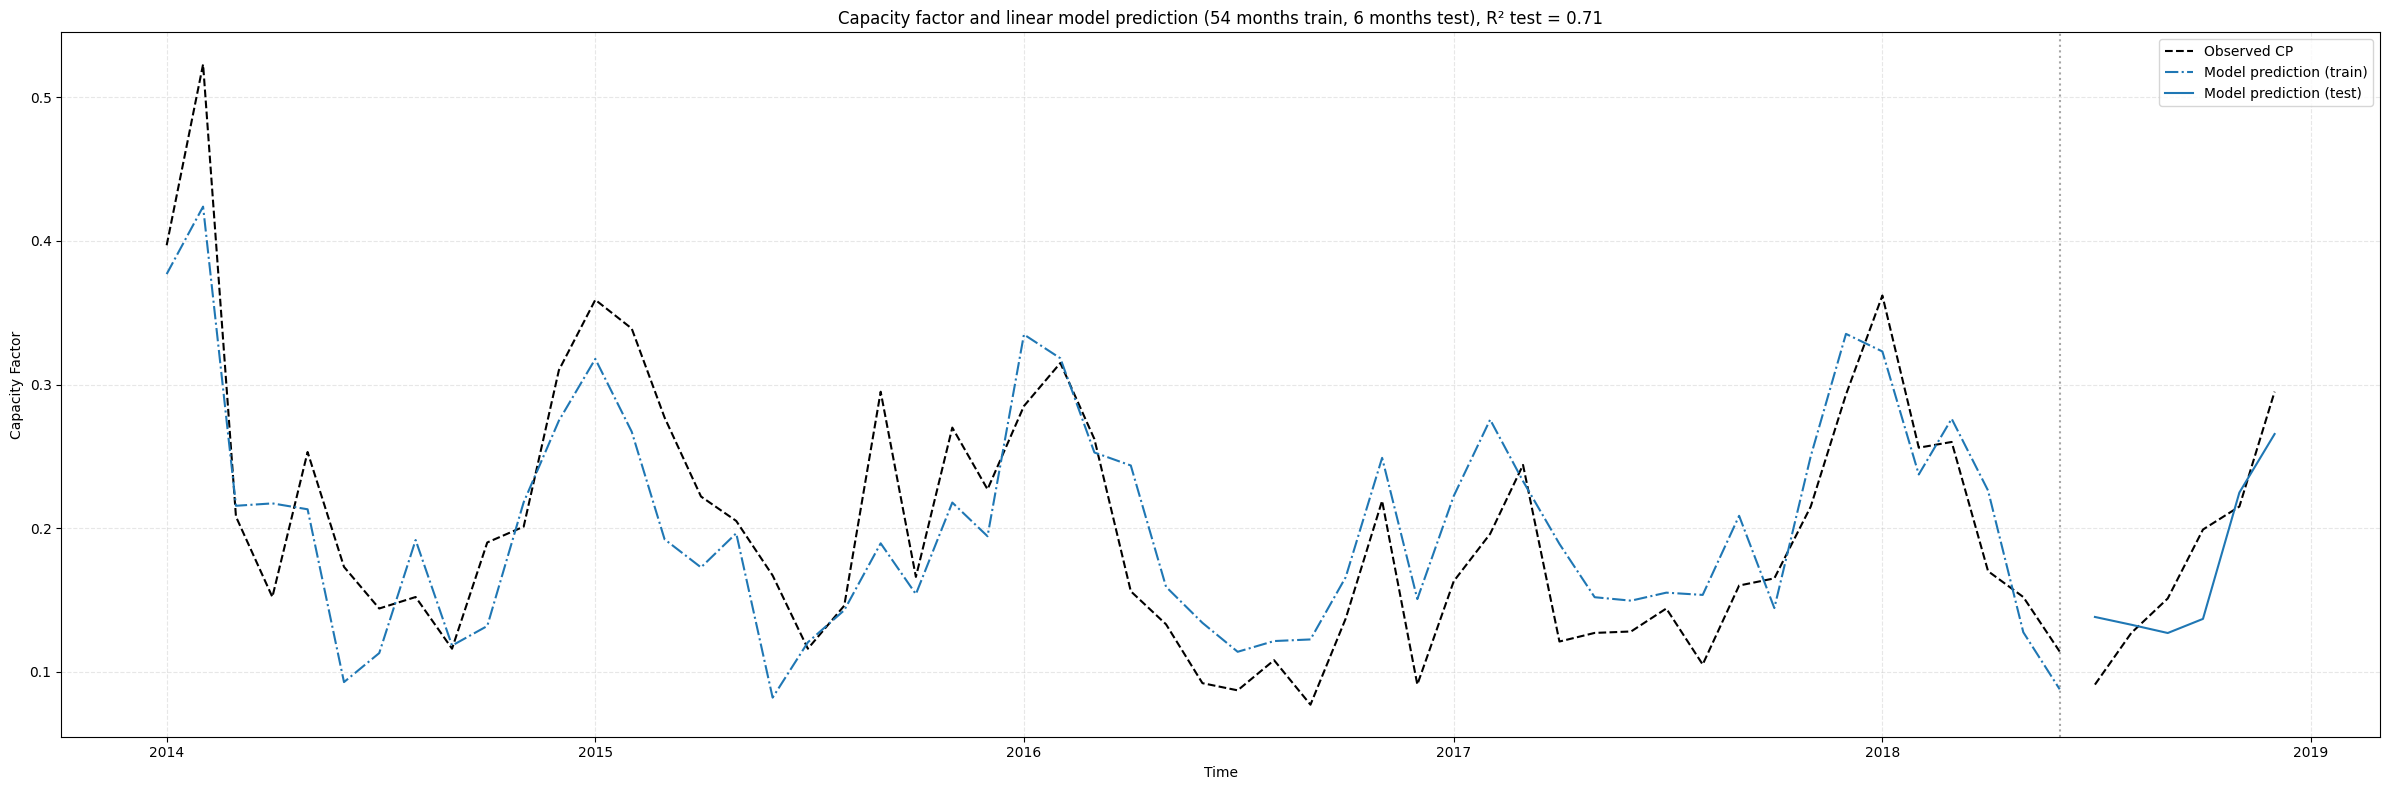

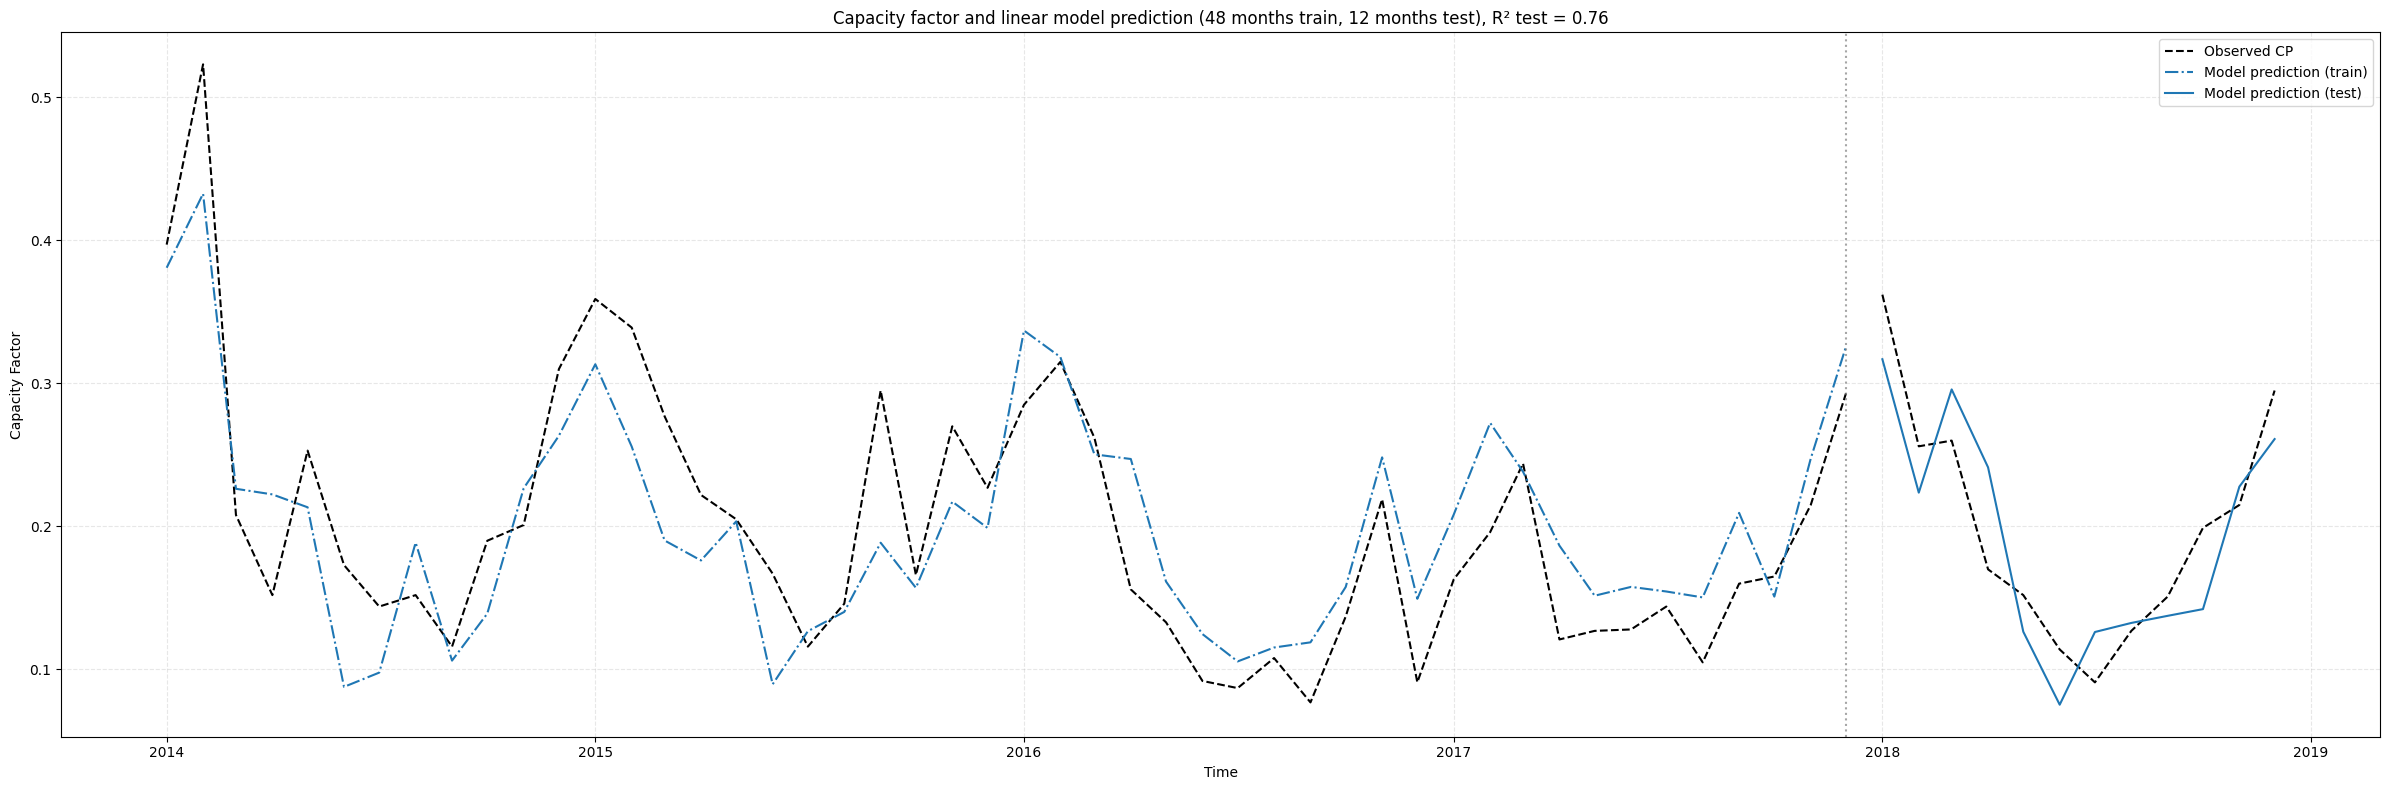

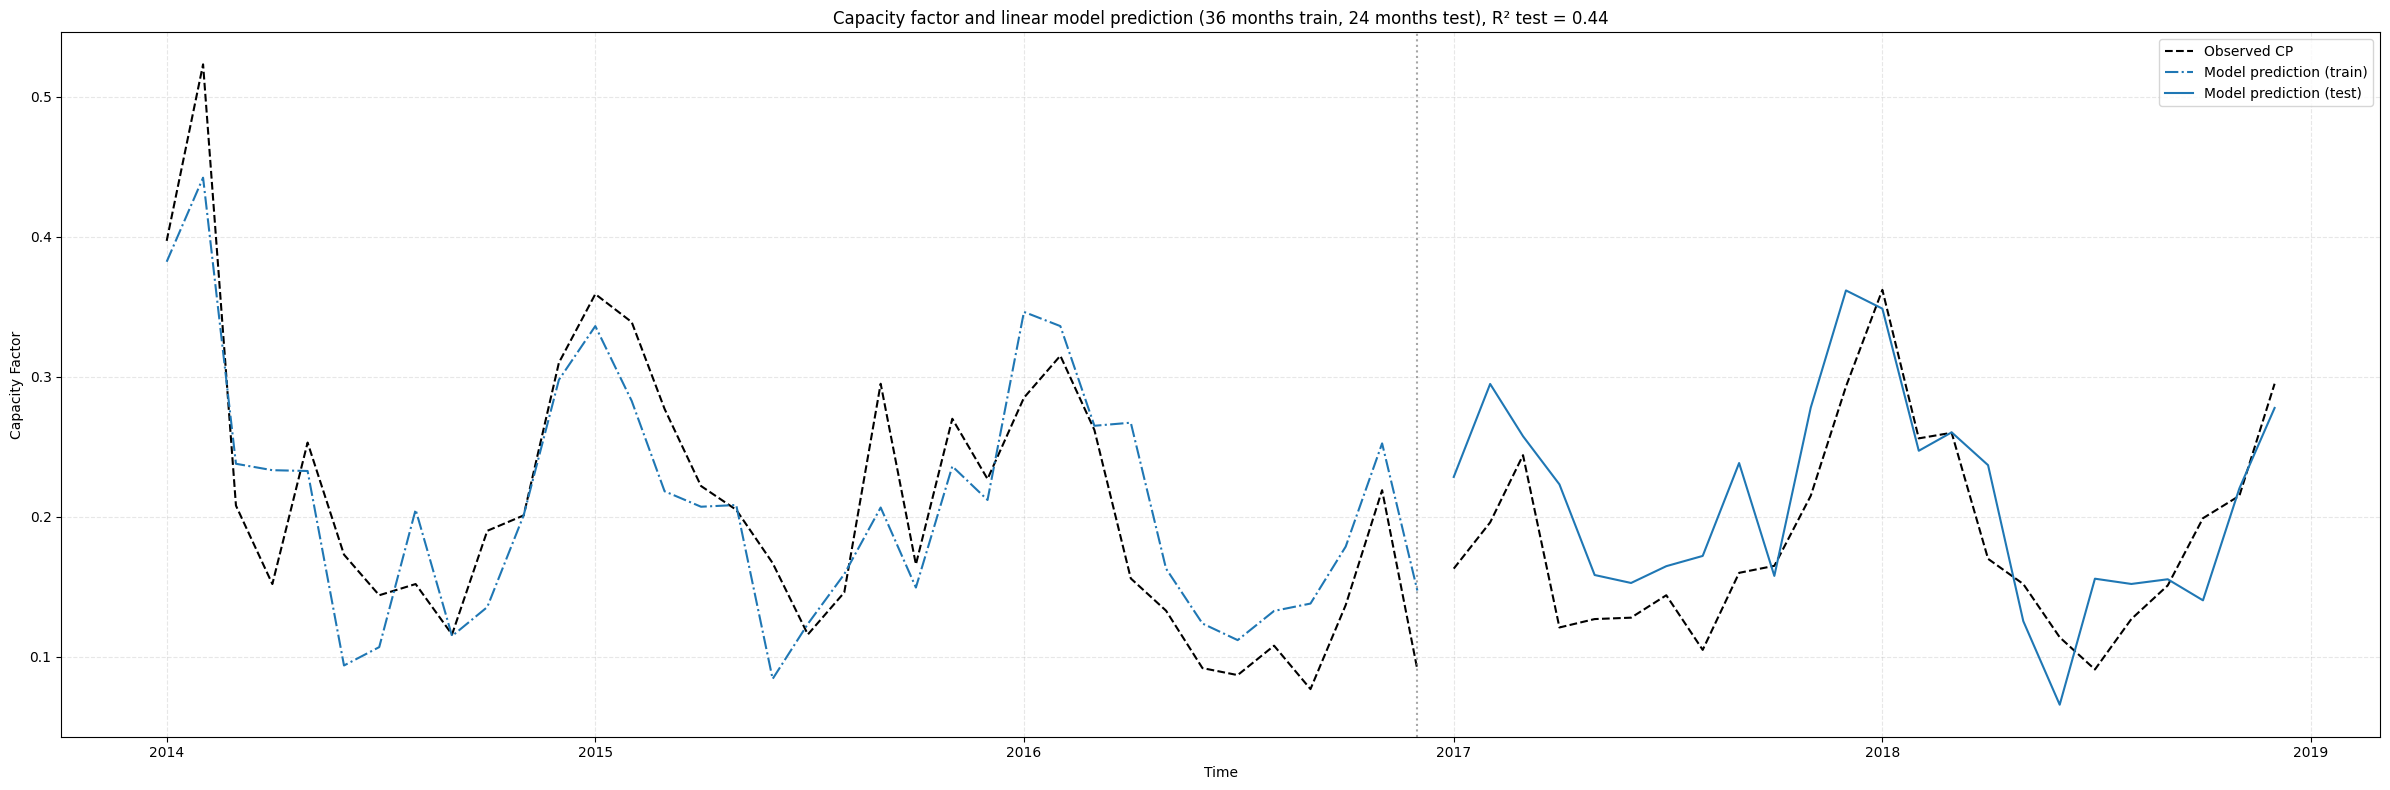

In [112]:
R2_6 = plot_linear_model_with_test_window(df_no2019, test_size=6)
R2_12 = plot_linear_model_with_test_window(df_no2019, test_size=12)
R2_24 = plot_linear_model_with_test_window(df_no2019, test_size=24)

Here we see a better performance and a more natural behaviour, where the R2 decreases but for a reason related to the decrease of training window.

### Training without zonal winds

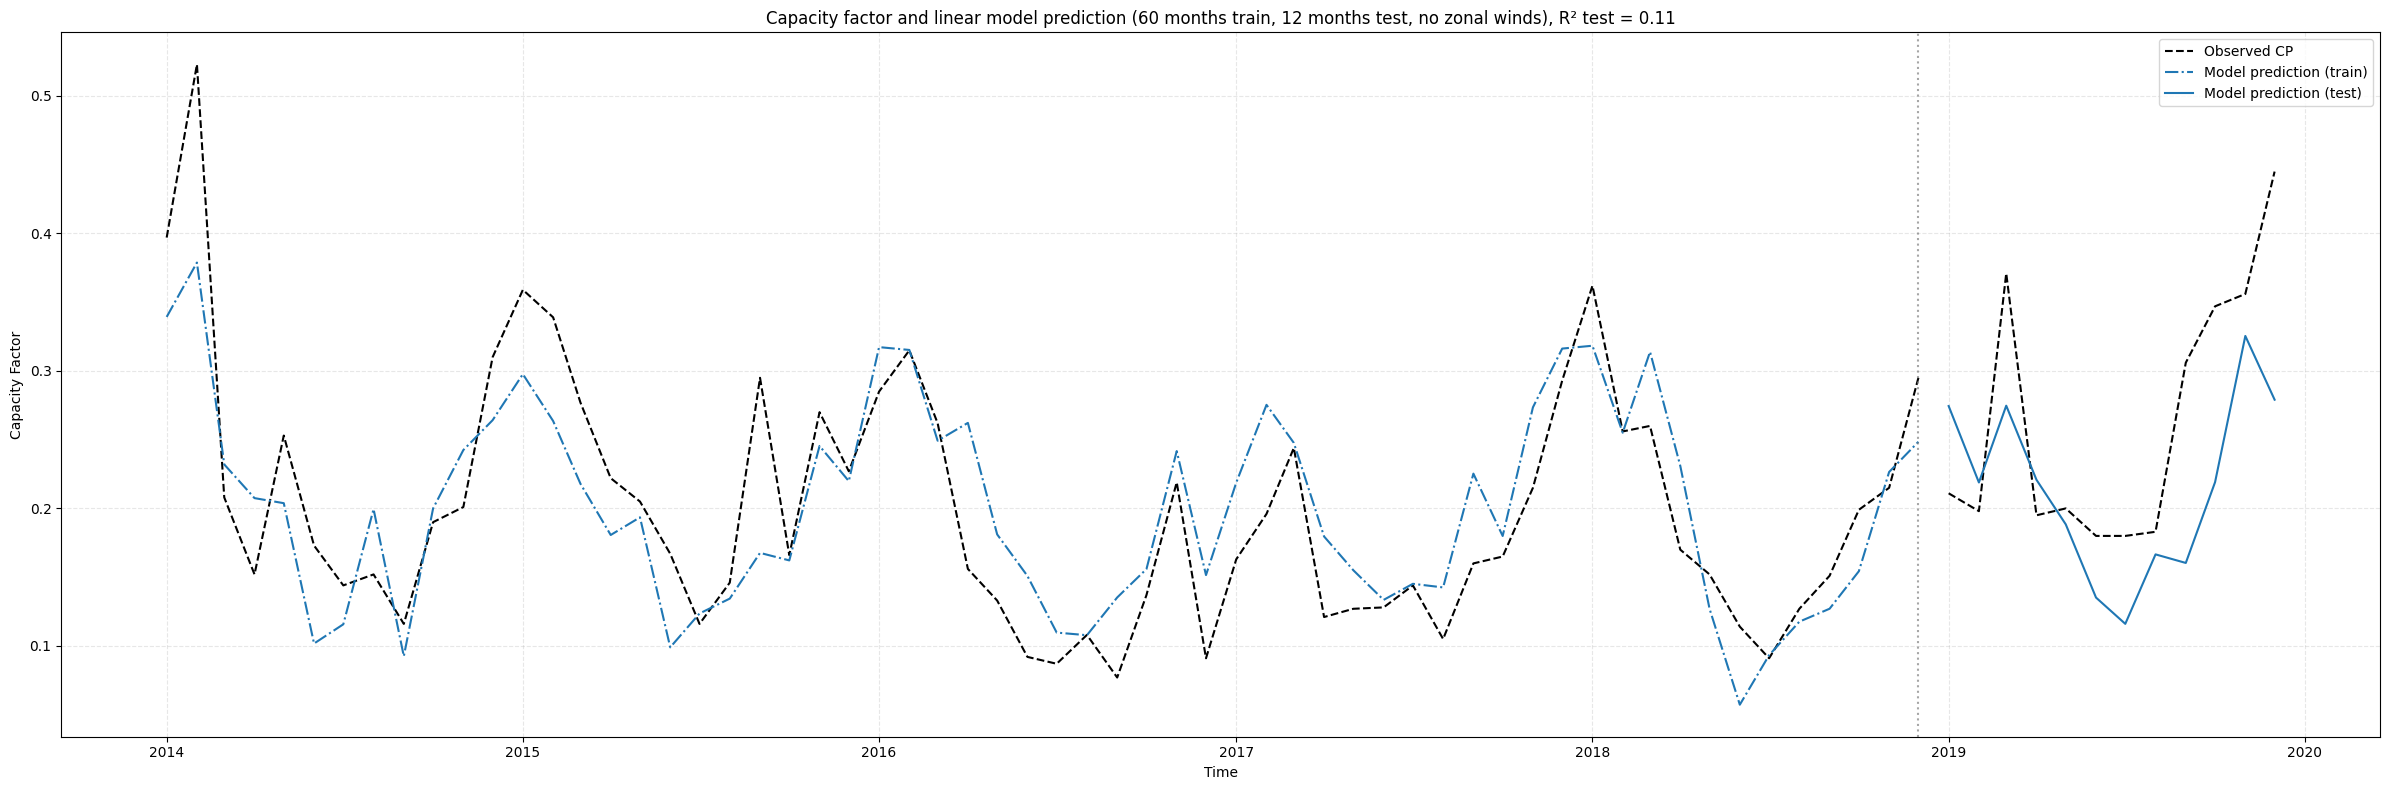

In [121]:
df = df_dataset.sort_index().copy()

# exclui capacity_factor, zonal_wind e upper_zonal_wind das features
X_full = df.drop(columns=["capacity_factor", "zonal_wind", "upper_meridional_wind"]).values
y_full = df["capacity_factor"].values
time_index = df.index

n_train = 60
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8  

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# regressão linear
model = LinearRegression().fit(X_train, y_train)

# predições
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# plot
plt.figure(figsize=(24,8))

# CP observado (treino + teste) em preto tracejado
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP'
)
plt.plot(
    time_index[n_train:],
    y_test,
    'k--'
)

# predição no treino (traço-ponto azul)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Model prediction (train)'
)

# predição no teste (linha contínua azul)
plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Model prediction (test)'
)

# linha vertical marcando fronteira treino/teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

R2_test = model.score(X_test, y_test)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Capacity factor and linear model prediction (60 months train, 12 months test, no zonal winds), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Training with the last 4 years instead of 5 years

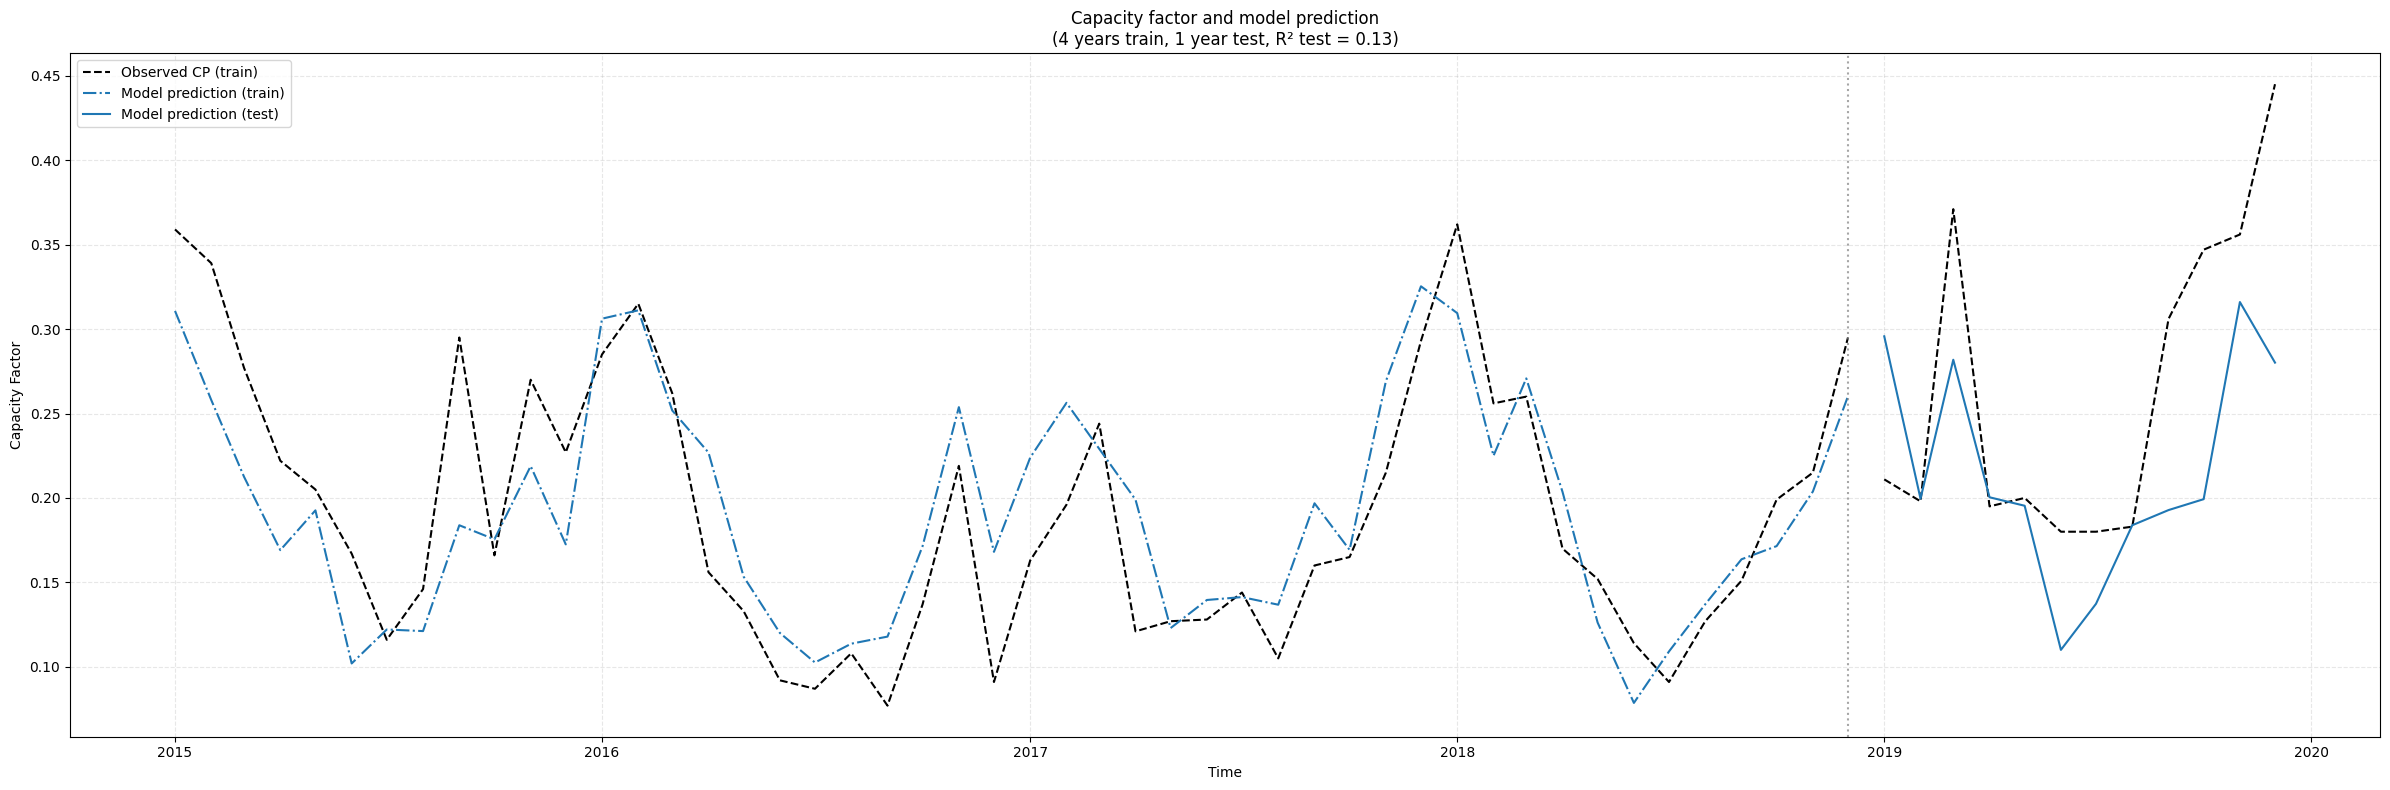

In [52]:
df_sub = df_dataset.sort_index().loc['2015-01-01':].copy()

X_full = df_sub.drop(columns=["capacity_factor"]).values
y_full = df_sub["capacity_factor"].values
time_index = df_sub.index

# 2) 4 anos de treino, 1 de teste (total = 5 anos = 60 meses)
n_months_per_year = 12
n_test  = 1 * n_months_per_year              # 1 ano de teste = 12 meses
n_train = len(df_sub) - n_test               # resto é treino (60 - 12 = 48 meses = 4 anos)

X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:n_train + n_test, :]
y_test = y_full[n_train:n_train + n_test]

# 3) Normalização com estatísticas APENAS do treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8  # evita divisão por zero

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# 4) Regressão linear
model = LinearRegression().fit(X_train, y_train)

# 5) Predições
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 6) Plot
plt.figure(figsize=(24,8))

# CP observado no treino
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP (train)'
)

plt.plot(
    time_index[n_train:],
    y_test,
    'k--',
)

# Predição do modelo no treino (azul traço-ponto)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Model prediction (train)'
)

# Predição do modelo no teste (azul contínuo)
plt.plot(
    time_index[n_train:n_train + n_test],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Model prediction (test)'
)

# Linha vertical separando treino e teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

R2_test = model.score(X_test, y_test)
plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Capacity factor and model prediction\n(4 years train, 1 year test, R² test = {R2_test:.2f})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



### **2.2 Ridge Regression (L2 Regularization)**

Ridge adds a penalty proportional to the **L2 norm** of the coefficients:

$$
\min_{\beta} ; \left( |y - X\beta|_2^2 + \alpha |\beta|_2^2 \right)
$$

where:

* $|\beta|_2 = \left( \sum_j \beta_j^2 \right)^{1/2}$
* $\alpha > 0$ is the regularization strength

The L2 penalty shrinks all coefficients toward zero but **never forces any of them to become exactly zero**.



### **2.3 Lasso Regression (L1 Regularization)**

Lasso adds a penalty proportional to the **L1 norm** of the coefficients:

$$
\min_{\beta} ; \left( |y - X\beta|_2^2 + \alpha |\beta|_1 \right)
$$

where:

* $|\beta|_1 = \sum_j |\beta_j|$

The L1 penalty encourages sparsity, meaning that **Lasso can force some coefficients to become exactly zero**, effectively performing feature selection.



## **3. Why the Norm Type and α Change Feature Importance**

### **Effect of the Regularization Term**

$
\text{Loss} = \underbrace{|y - X\beta|_2^2}_{\text{fit to data}} + \underbrace{\alpha \cdot R(\beta)}_{\text{regularization}}
$

where:

* $R(\beta)$ is either the L1 or L2 norm
* **α controls how much the regularization term influences the optimization**


### **How the Norms Affect β**

#### **L2 norm (Ridge)**

* Penalizes **large values** of $\beta_j$
* Encourages coefficients to be **small but not zero**
* Reduces variance and stabilizes the model under multicollinearity
* Keeps all features in the model but decreases their influence

#### **L1 norm (Lasso)**

* Penalizes the **absolute value** of coefficients
* Has a geometric shape with **sharp corners** at zero
* These corners encourage coefficients to become **exactly zero**
* Performs automatic **feature selection**


### **Role of α**

α scales the strength of the penalty:

* If **α = 0**, Ridge and Lasso reduce to ordinary least squares
* If **α increases**:

  * Ridge shrinks coefficients smoothly
  * Lasso forces more coefficients to zero

Thus, **the choice of norm and the magnitude of α directly determine the final feature importance** by controlling how the model balances accuracy vs. coefficient size.


## Ridge Regression

In [ ]:
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index


test_size = 12
n_samples = len(df)

X_test_final = X_full[-test_size:]
y_test_final = y_full[-test_size:]


X_cv_full = X_full[:-test_size]
y_cv_full = y_full[:-test_size]

def select_alpha_nested_ridge(
    X, y,
    alphas,
    val_size=12,
    min_train_size=24,
    step=12
):


    n = len(y)
    train_ends = range(min_train_size, n - val_size + 1, step)

    r2_mean = []

    for alpha in alphas:
        fold_scores = []

        for train_end in train_ends:
            
            X_train_raw = X[:train_end]
            y_train = y[:train_end]

            X_val_raw = X[train_end:train_end + val_size]
            y_val = y[train_end:train_end + val_size]

           
            mean = X_train_raw.mean(axis=0)
            std = X_train_raw.std(axis=0)
            std[std == 0] = 1e-8

            X_train = (X_train_raw - mean) / std
            X_val = (X_val_raw - mean) / std

            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)

            fold_scores.append(model.score(X_val, y_val))

        r2_mean.append(np.mean(fold_scores))

    r2_mean = np.array(r2_mean)
    best_idx = np.argmax(r2_mean)

    return alphas[best_idx], r2_mean, train_ends


alphas = np.logspace(-3, 5, 60)

best_alpha, r2_mean, train_ends = select_alpha_nested_ridge(
    X_cv_full,
    y_cv_full,
    alphas,
    val_size=12,
    min_train_size=24,
    step=12
)

print("Best alpha (nested CV):", best_alpha)
print("Best mean validation R²:", r2_mean.max())

mean = X_cv_full.mean(axis=0)
std = X_cv_full.std(axis=0)
std[std == 0] = 1e-8

X_train_final = (X_cv_full - mean) / std
X_test_final_norm = (X_test_final - mean) / std

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_final, y_cv_full)

R2_test_final = final_model.score(X_test_final_norm, y_test_final)

print("Final test R² (2019):", R2_test_final)


Best alpha (nested CV): 40.75392965871778
Best mean validation R²: 0.2729608366739516
Final test R² (2019): 0.0029875982620685138


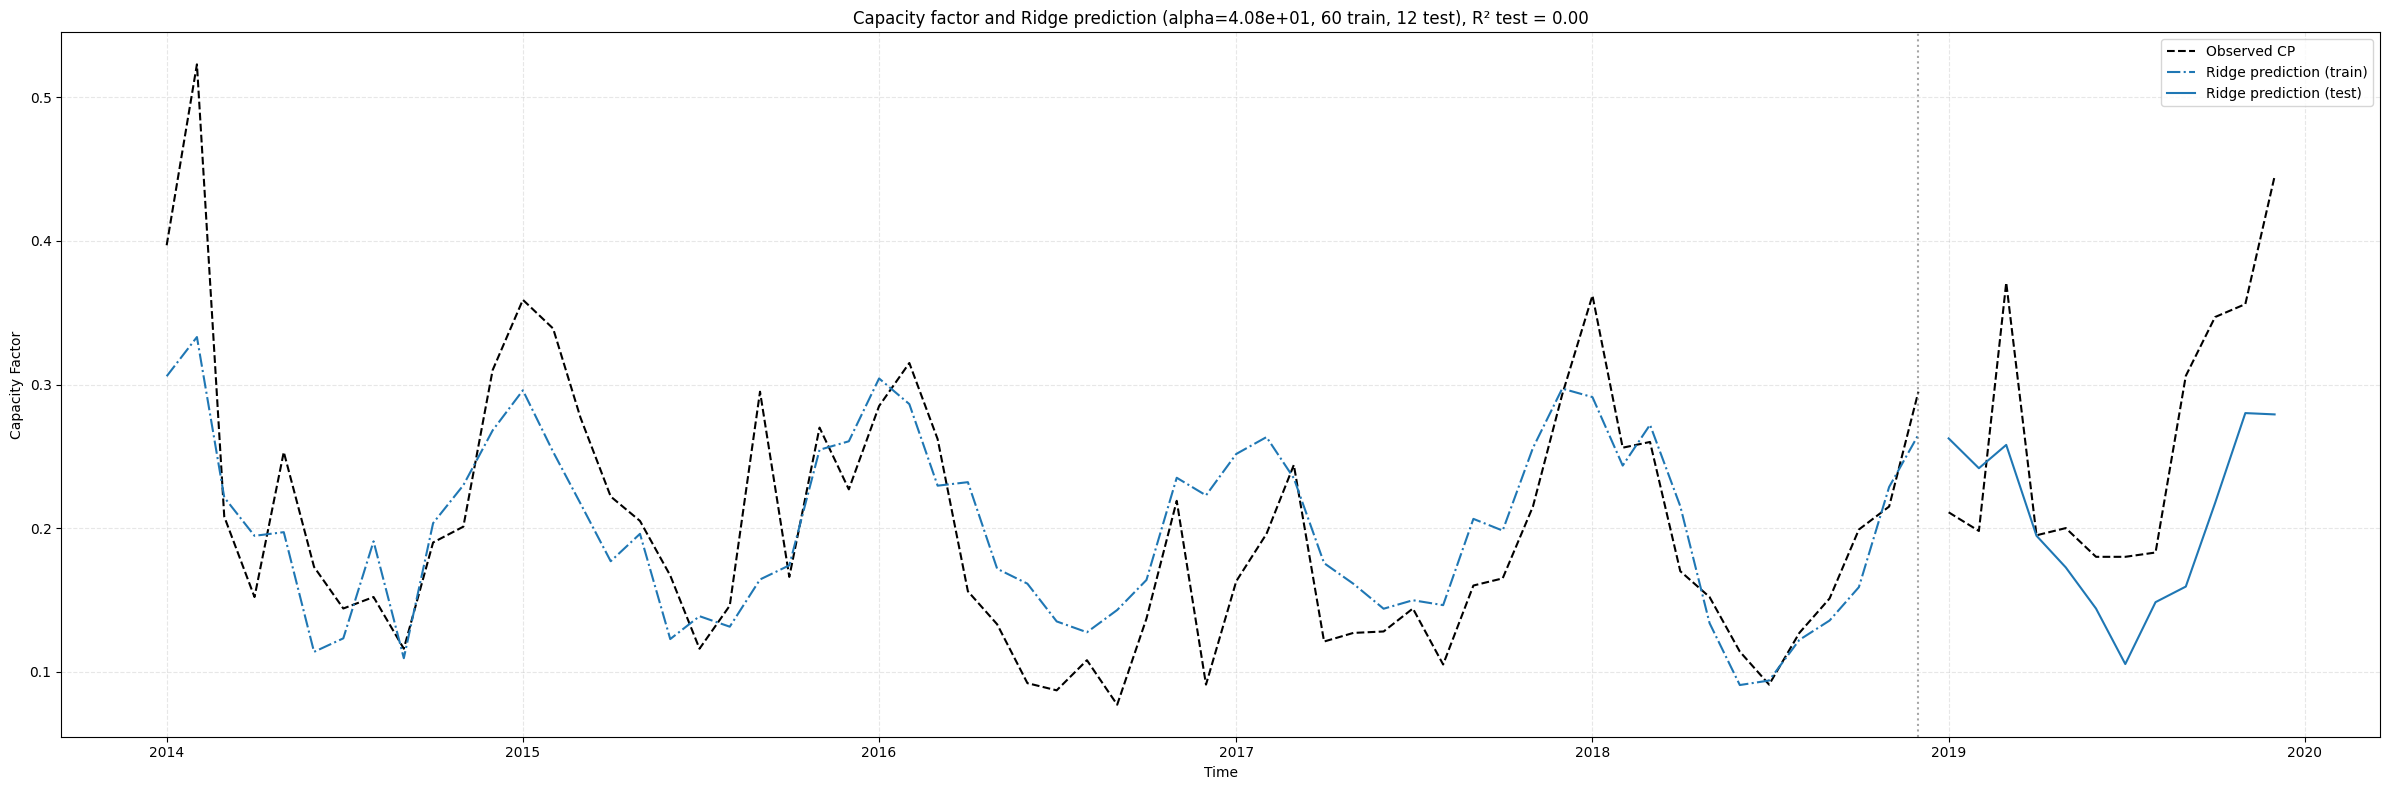

In [130]:
# df_dataset: dataset completo (2014–2019), com capacity_factor
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

# teste final (últimos 12 meses)
test_size = 12
n_samples = len(df)
n_train = n_samples - test_size

# split final (treino = tudo menos o teste final)
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]
X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

# normalização APENAS com o treino final
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# Ridge com alpha escolhido
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

# predições
y_pred_train = ridge.predict(X_train)
y_pred_test  = ridge.predict(X_test)

# R² no teste final
R2_test = ridge.score(X_test, y_test)

# plot no mesmo estilo
plt.figure(figsize=(24,8))

# CP observado (treino + teste) em preto tracejado
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP'
)
plt.plot(
    time_index[n_train:],
    y_test,
    'k--'
)

# predição no treino (azul traço-ponto)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Ridge prediction (train)'
)

# predição no teste (azul contínuo)
plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Ridge prediction (test)'
)

# fronteira treino/teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(
    f"Capacity factor and Ridge prediction (alpha={best_alpha:.2e}, "
    f"{n_train} train, {test_size} test), R² test = {R2_test:.2f}"
)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Best alpha (nested, up to 2018): 40.75392965871778
Best mean validation R²: 0.2729608366739516


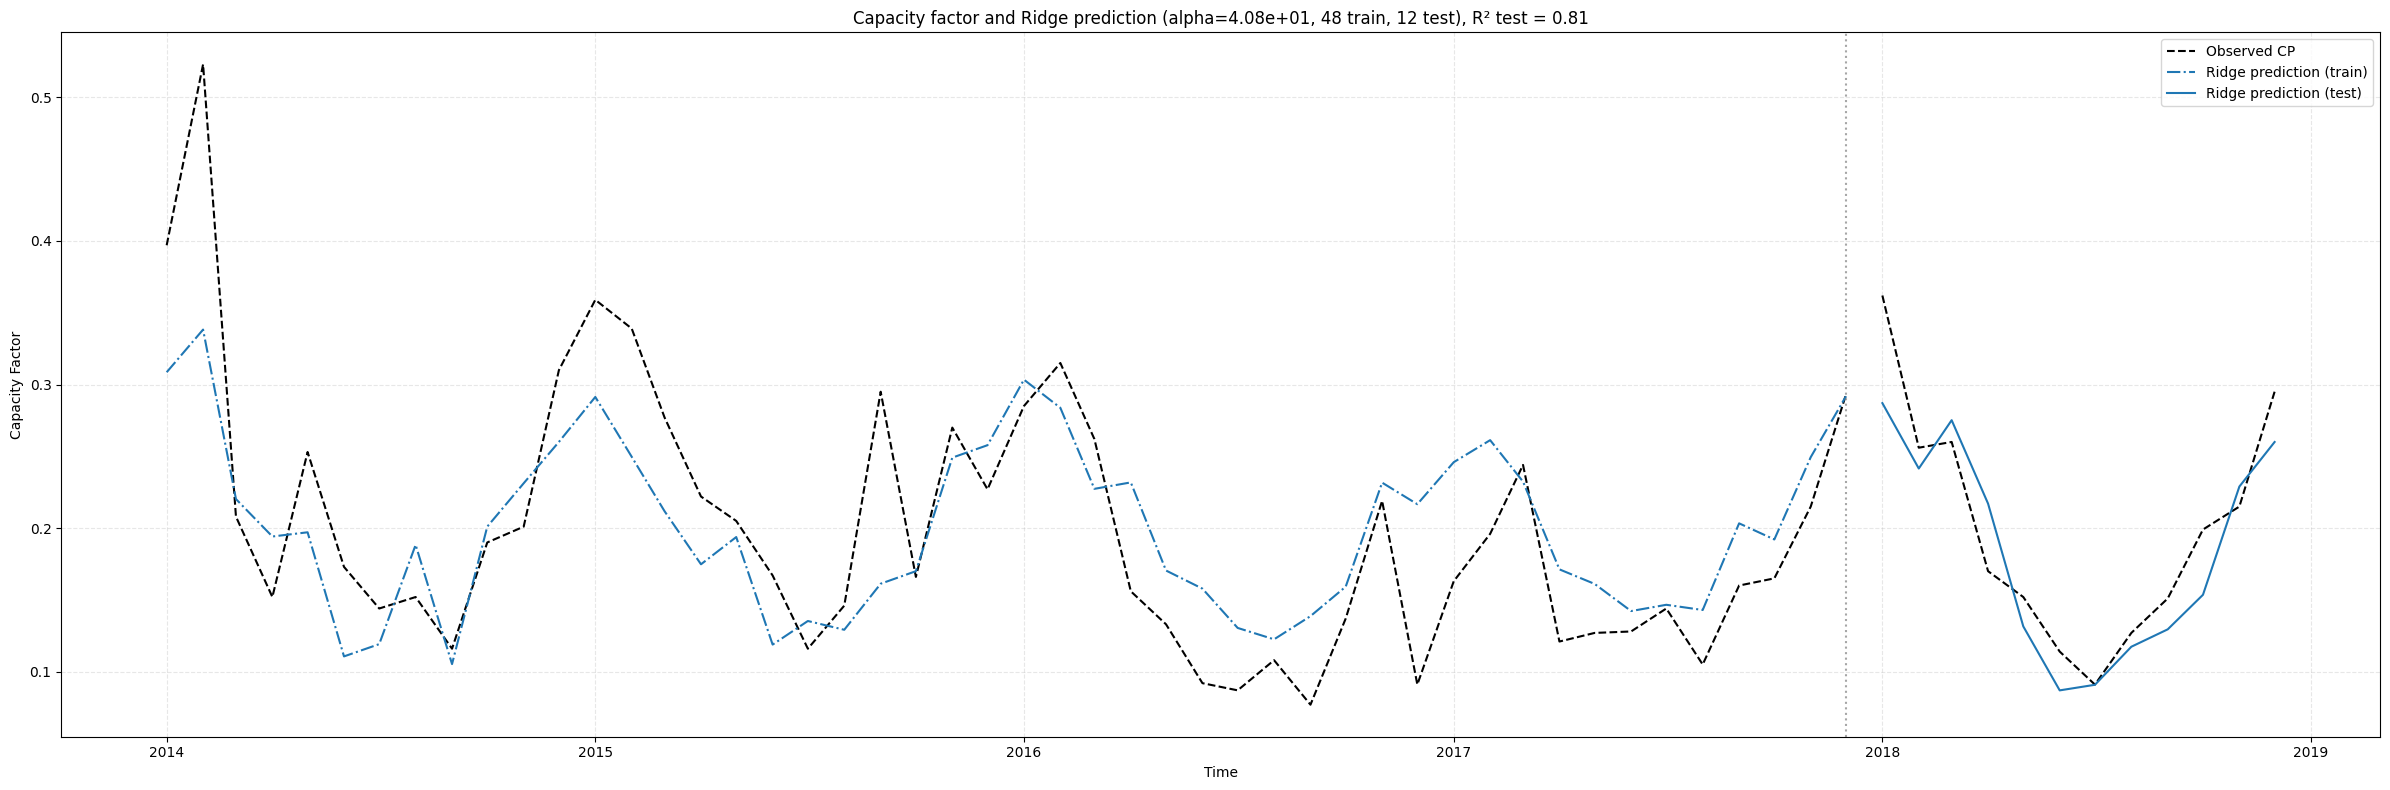

In [132]:
df_2018 = df_dataset.sort_index().loc[:'2018-12-01'].copy()

X_full = df_2018.drop(columns=["capacity_factor"]).values
y_full = df_2018["capacity_factor"].values
time_index = df_2018.index

alphas = np.logspace(-3, 5, 60)

best_alpha_2018, r2_mean_2018, _ = select_alpha_nested_ridge(
    X_full, y_full, alphas,
    val_size=12, min_train_size=24, step=12
)


print("Best alpha (nested, up to 2018):", best_alpha_2018)
print("Best mean validation R²:", r2_mean_2018.max())


# Último ano (2018) como teste
test_size = 12
n_samples = len(df_2018)
n_train = n_samples - test_size

X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

# Normalização só com o treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# Ridge com alpha escolhido
ridge = Ridge(alpha=best_alpha_2018)
ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test  = ridge.predict(X_test)

R2_test = ridge.score(X_test, y_test)

# Plot no mesmo estilo
plt.figure(figsize=(24,8))

# Observado (preto tracejado)
plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
plt.plot(time_index[n_train:], y_test, 'k--')

# Predição no treino (azul traço-ponto)
plt.plot(time_index[:n_train], y_pred_train, color='C0', linestyle='-.',
         label='Ridge prediction (train)')

# Predição no teste (azul contínuo)
plt.plot(time_index[n_train:], y_pred_test, color='C0', linestyle='-',
         label='Ridge prediction (test)')

# Fronteira treino/teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(
    f"Capacity factor and Ridge prediction (alpha={best_alpha_2018:.2e}, "
    f"{n_train} train, {test_size} test), R² test = {R2_test:.2f}"
)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def ridge_feature_importance(df, alpha, test_size=12):
    """
    Train Ridge on df[:-test_size] and return absolute standardized coefficients.
    """
    df = df.sort_index().copy()

    X = df.drop(columns=["capacity_factor"]).values
    y = df["capacity_factor"].values
    feature_names = df.drop(columns=["capacity_factor"]).columns

    n_train = len(df) - test_size

    X_train_raw = X[:n_train]
    y_train = y[:n_train]

    # standardization (train only)
    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)
    std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std

    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    importance = np.abs(model.coef_)

    return pd.Series(importance, index=feature_names).sort_values(ascending=False)


In [138]:
importance_with_2019 = ridge_feature_importance(
    df_dataset,
    alpha=best_alpha,      # alpha escolhido com nested CV até 2019
    test_size=12
)

importance_without_2019 = ridge_feature_importance(
    df_no2019,
    alpha=best_alpha_2018,  # alpha escolhido com nested CV até 2018
    test_size=12
)

#importance_with_2019,importance_without_2019



<Figure size 1200x600 with 0 Axes>

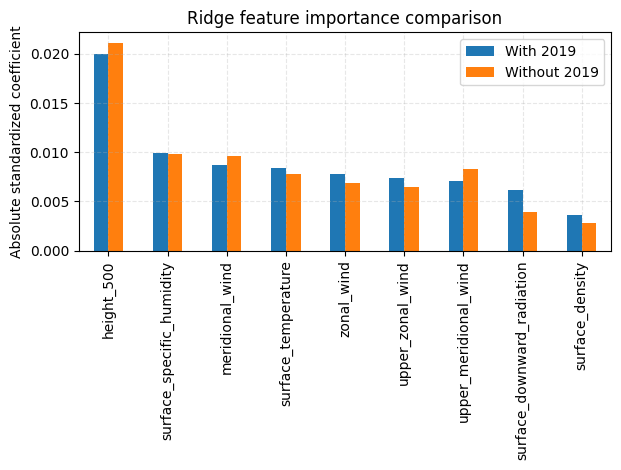

In [ ]:
imp_df = pd.concat(
    [importance_with_2019, importance_without_2019],
    axis=1,
    keys=["With 2019", "Without 2019"]
).fillna(0)

plt.figure(figsize=(12,6))
imp_df.plot(kind="bar")
plt.ylabel("Absolute standardized coefficient")
plt.title("Ridge feature importance comparison")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Lasso regression

In [143]:
def select_alpha_nested_lasso(X, y, alphas, val_size=12, min_train_size=24, step=12, max_iter=20000):
    """
    Escolhe alpha via walk-forward validation (expanding window), sem usar teste final.
    Retorna: best_alpha, r2_mean, train_ends
    """
    n = len(y)
    train_ends = list(range(min_train_size, n - val_size + 1, step))

    r2_mean = []

    for alpha in alphas:
        fold_scores = []

        for train_end in train_ends:
            X_train_raw = X[:train_end]
            y_train = y[:train_end]

            X_val_raw = X[train_end:train_end + val_size]
            y_val = y[train_end:train_end + val_size]

            # normalização apenas com treino
            mean = X_train_raw.mean(axis=0)
            std  = X_train_raw.std(axis=0)
            std[std == 0] = 1e-8

            X_train = (X_train_raw - mean) / std
            X_val   = (X_val_raw  - mean) / std

            model = Lasso(alpha=alpha, max_iter=max_iter)
            model.fit(X_train, y_train)

            fold_scores.append(model.score(X_val, y_val))

        r2_mean.append(np.mean(fold_scores))

    r2_mean = np.array(r2_mean)
    best_idx = np.argmax(r2_mean)

    return alphas[best_idx], r2_mean, train_ends

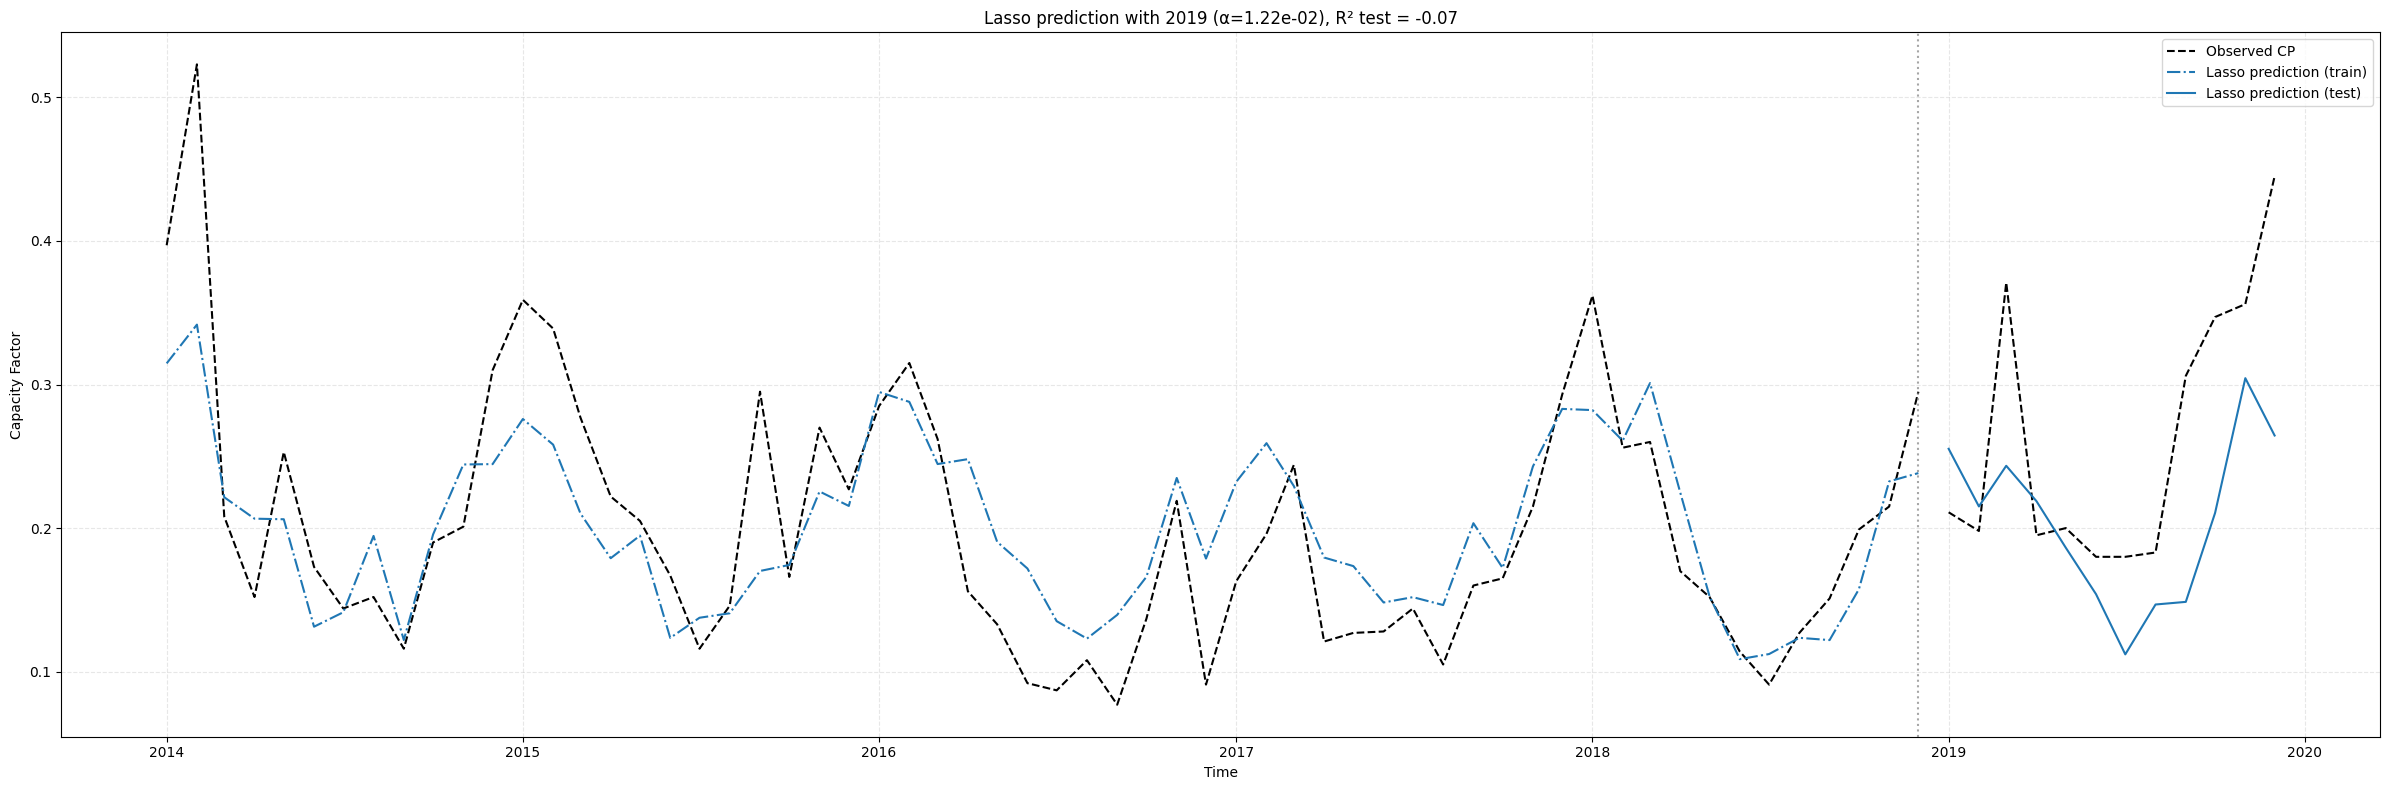

In [149]:
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

# teste final = 2019
test_size = 12
n_train = len(df) - test_size

X_train_raw = X_full[:n_train]
y_train = y_full[:n_train]
X_test_raw  = X_full[n_train:]
y_test = y_full[n_train:]

# normalização APENAS com treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

alphas = np.logspace(-3, 5, 60)

best_alpha_lasso = select_alpha_nested_lasso(X_full, y_full, alphas)[0]
lasso_2019 = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_2019.fit(X_train, y_train)

y_pred_train = lasso_2019.predict(X_train)
y_pred_test  = lasso_2019.predict(X_test)

R2_test = lasso_2019.score(X_test, y_test)

# plot
plt.figure(figsize=(24,8))

plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
plt.plot(time_index[n_train:], y_test, 'k--')

plt.plot(time_index[:n_train], y_pred_train,
         color='C0', linestyle='-.', label='Lasso prediction (train)')

plt.plot(time_index[n_train:], y_pred_test,
         color='C0', linestyle='-', label='Lasso prediction (test)')

plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Lasso prediction with 2019 (α={best_alpha_lasso:.2e}), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


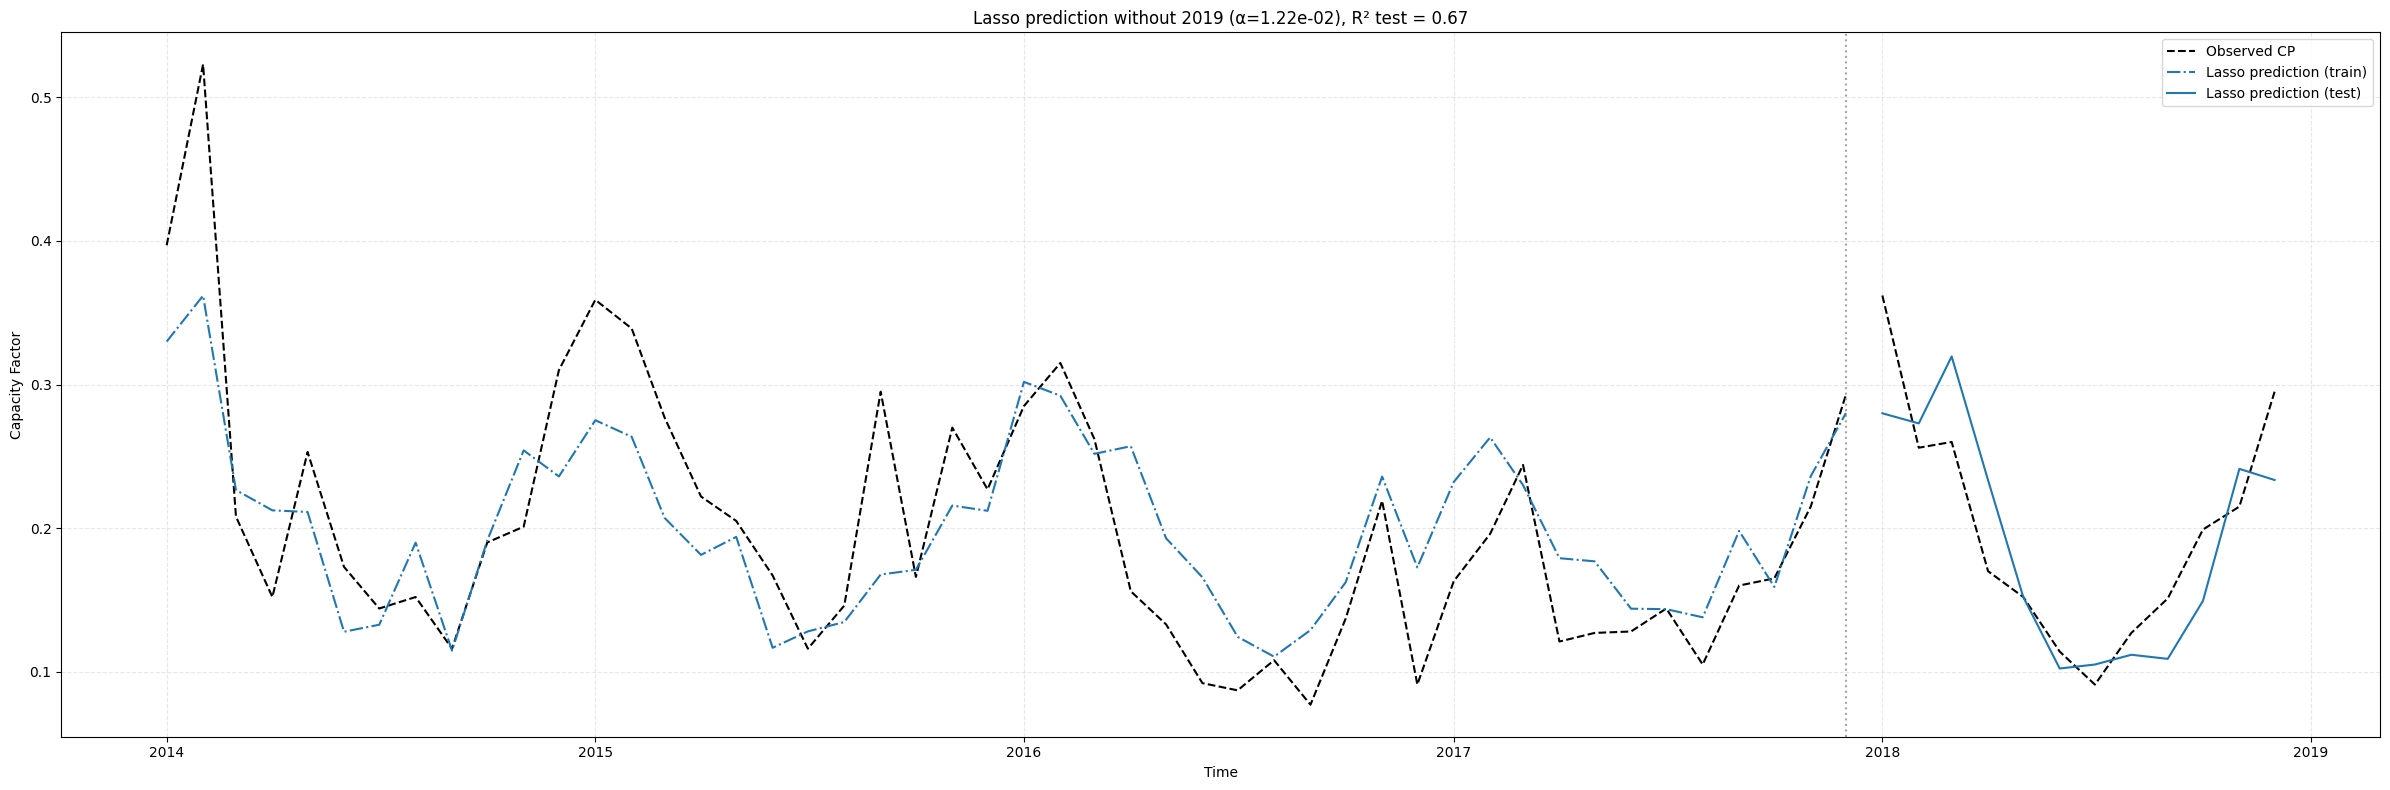

In [150]:
df_2018 = df_dataset.sort_index().loc[:'2018-12-01'].copy()

X_full = df_2018.drop(columns=["capacity_factor"]).values
y_full = df_2018["capacity_factor"].values
time_index = df_2018.index

test_size = 12
n_train = len(df_2018) - test_size

X_train_raw = X_full[:n_train]
y_train = y_full[:n_train]
X_test_raw  = X_full[n_train:]
y_test = y_full[n_train:]

mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std


best_alpha_lasso_2018 = select_alpha_nested_lasso(X_full, y_full, alphas)[0]
lasso_2018 = Lasso(alpha=best_alpha_lasso_2018, max_iter=10000)
lasso_2018.fit(X_train, y_train)

y_pred_train = lasso_2018.predict(X_train)
y_pred_test  = lasso_2018.predict(X_test)

R2_test = lasso_2018.score(X_test, y_test)

plt.figure(figsize=(24,8))

plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
plt.plot(time_index[n_train:], y_test, 'k--')

plt.plot(time_index[:n_train], y_pred_train,
         color='C0', linestyle='-.', label='Lasso prediction (train)')

plt.plot(time_index[n_train:], y_pred_test,
         color='C0', linestyle='-', label='Lasso prediction (test)')

plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Lasso prediction without 2019 (α={best_alpha_lasso_2018:.2e}), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

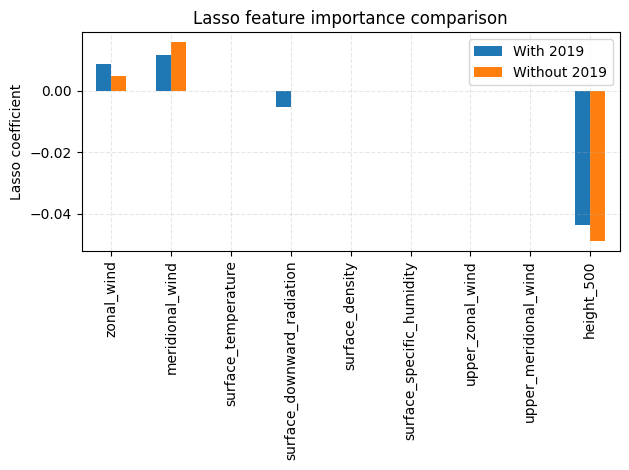

In [152]:
def lasso_feature_importance(df, alpha, test_size=12):
    df = df.sort_index().copy()

    X = df.drop(columns=["capacity_factor"]).values
    y = df["capacity_factor"].values
    features = df.drop(columns=["capacity_factor"]).columns

    n_train = len(df) - test_size

    X_train_raw = X[:n_train]
    y_train = y[:n_train]

    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)
    std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std

    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)

    return pd.Series(model.coef_, index=features)

imp_lasso_2018 = lasso_feature_importance(
    df_2018,
    alpha=best_alpha_lasso_2018,
    test_size=12
)

imp_lasso_2019 = lasso_feature_importance(
    df_dataset,
    alpha=best_alpha_lasso,
    test_size=12
)


imp_df = pd.concat(
    [imp_lasso_2019, imp_lasso_2018],
    axis=1,
    keys=["With 2019", "Without 2019"]
).fillna(0)

plt.figure(figsize=(12,6))
imp_df.plot(kind='bar')
plt.ylabel("Lasso coefficient")
plt.title("Lasso feature importance comparison")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>